In [1]:

suppressMessages(library(tidyverse))
suppressMessages(library(parallel))
suppressMessages(library(Seurat))
suppressMessages(library(SeuratData))
suppressMessages(library(patchwork))
suppressMessages(library(Matrix))
suppressMessages(library(viridis))
suppressMessages(library(cowplot))
suppressMessages(library(ggsci))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(reshape2))
suppressMessages(library(LSD))
suppressMessages(library(readxl))
suppressMessages(library(ggrepel))
suppressMessages(library(randomForest))
suppressMessages(library(harmony))

# Plot each clusters
myHighlightDimPlot = function(seuratObj, highlightBy, size=1, alpha=1, showAllPoints=FALSE, ...) {
    umapTb = as_tibble(seuratObj@reductions$umap@cell.embeddings)
    if (!identical(rownames(seuratObj@reductions$umap@cell.embeddings), rownames(seuratObj@meta.data)))
        stop("Error: cell names not identical!")
    umapTb = cbind(umapTb, seuratObj@meta.data)
    highlightByClass = sort(unique(umapTb[[highlightBy]]))
    gpList = lapply(highlightByClass, function(cl) {
        subUmapTb = subset(umapTb, umapTb[[highlightBy]] == cl)
        if (showAllPoints) {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void() 
        } else {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void()
        }
        return(gp)
    })
    gpAll = plot_grid(plotlist=gpList, labels=highlightByClass, ...)
    return(gpAll)
}

In [2]:
seurat=readRDS('/home/liuyx/liuyuxuan/spa_seurat/cla/renew_data0425/sn_rna_data/snrna_matrix_20230420/sum_data/maca/macaca_snrna_all_soupX_unfil_0425.rds')

seurat



An object of class Seurat 
21680 features across 244523 samples within 1 assay 
Active assay: RNA (21680 features, 0 variable features)

In [3]:
table(seurat@meta.data$group)


6103-1 6103-2 6103-3 6103-4 6103-5 6103-6 6712-1 6712-2 6712-3 6712-4 7220-1 
  8029   8216   8128   8236   7975   8627   7637   7805   7531   8000   8283 
7220-2 7221-1 7221-2 7222-1 7222-2 7223-1 7223-2 7224-1 7224-2 7230-1 7230-2 
  8015   8291   8338   7556   7602   8079   8014   8291   8247   8530   8539 
7231-1 7231-2 7231-3 7232-1 7232-2 7232-3 7248-1 7248-2 
  8295   8090   8352   8574   8303   8548   8167   8225 

In [4]:
#去除 median nfeature <500
df_meta=seurat@meta.data
group_med_feature=df_meta %>% group_by(group)  %>% summarise(med=median(nFeature_RNA))
select_group=group_med_feature[group_med_feature$med > 500,]$group
#被去掉的文库
length(group_med_feature$group)
group_med_feature[group_med_feature$med < 500,]$group
length(select_group)

seurat=subset(seurat,group %in% select_group)



[1] 30

[1] "6103-3" "6103-4" "6103-5" "6103-6" "7230-1" "7230-2" "7231-1" "7231-2"
 [9] "7231-3" "7232-1" "7232-2" "7232-3"

[1] 17

In [5]:
libMetaTb[libMetaTb$libId %in% group_med_feature[group_med_feature$med < 500,]$group,]
   

ERROR: Error in parse(text = x, srcfile = src): <text>:2:1: unexpected input
1: libMetaTb[libMetaTb$libId %in% group_med_feature[group_med_feature$med < 500,]$group,]
2:  
   ^


In [6]:
seurat

An object of class Seurat 
21680 features across 136110 samples within 1 assay 
Active assay: RNA (21680 features, 0 variable features)

In [7]:
libMetaTb = read_xlsx(paste0(
    "/home/liuyx/liuyuxuan/spa_seurat/cla", 
    "/sample_lib_meta.xlsx"
))
libMetaTb=libMetaTb[,c('tissue','sampleID')]
colnames(libMetaTb)=c('sampleId','sampleID')
libMetaTb$libId=str_extract(libMetaTb$sampleID,'[0-9][0-9][0-9][0-9]-[0-9]')
libMetaTb$sampleID=NULL
libMetaTb=libMetaTb[!(is.na(libMetaTb$libId)),]
head(libMetaTb)

New names:
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
• `` -> `...10`
• `` -> `...11`
• `` -> `...12`
• `` -> `...13`


sampleId,libId
<chr>,<chr>
Cla-rostral,6103-1
Cla-rostral,6103-2
Cla-rostral,6103-3
Cla-rostral,6103-4
Cla-rostral,6103-5
Cla-rostral,6103-6


In [8]:
seurat@meta.data$libId=seurat@meta.data$group

tmpMetaTb = as_tibble(seurat@meta.data[c("libId")])
tmpMetaTb$cellId = rownames(seurat@meta.data)
tmpMetaTb = left_join(tmpMetaTb, libMetaTb[c("sampleId", "libId")], by="libId")
tmpMetaTb = column_to_rownames(tmpMetaTb, var="cellId")
identical(rownames(tmpMetaTb), rownames(seurat@meta.data))
# str(tmpMetaTb)
seurat = AddMetaData(seurat, tmpMetaTb)
seurat$sampleId = factor(seurat$sampleId)
seurat$libId = factor(seurat$libId)

setdiff(libMetaTb$libId, unique(seurat$libId))
length(setdiff(libMetaTb$libId, unique(seurat$libId)))

MTGenes = c("ND6","COX3","COX1","ND5","ND4","ND2","ND4L","ATP8","CYTB","COX2","ND3","ATP6","ND1")
seurat[["percent.mt"]] <- PercentageFeatureSet(seurat,features = MTGenes)




[1] TRUE

[1] "6103-2" "6103-3" "6103-4" "6103-5" "6103-6" "6708-1" "6708-2" "6708-3"
 [9] "6708-4" "7230-1" "7230-2" "7231-1" "7231-2" "7231-3" "7232-1" "7232-2"
[17] "7232-3"

[1] 17

In [9]:
# Basic filtering
#修改为200
oriCellNum = ncol(seurat)
seurat$countFeatureRatio = seurat$nCount_RNA / seurat$nFeature_RNA
seurat = subset(seurat, nFeature_RNA > 300 & percent.mt < 5 & countFeatureRatio > 1.2)
cellNum1 = ncol(seurat)
cellNum1
message("Filter ratio: ", cellNum1/oriCellNum)

[1] 116934

Filter ratio: 0.859113951950628



Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


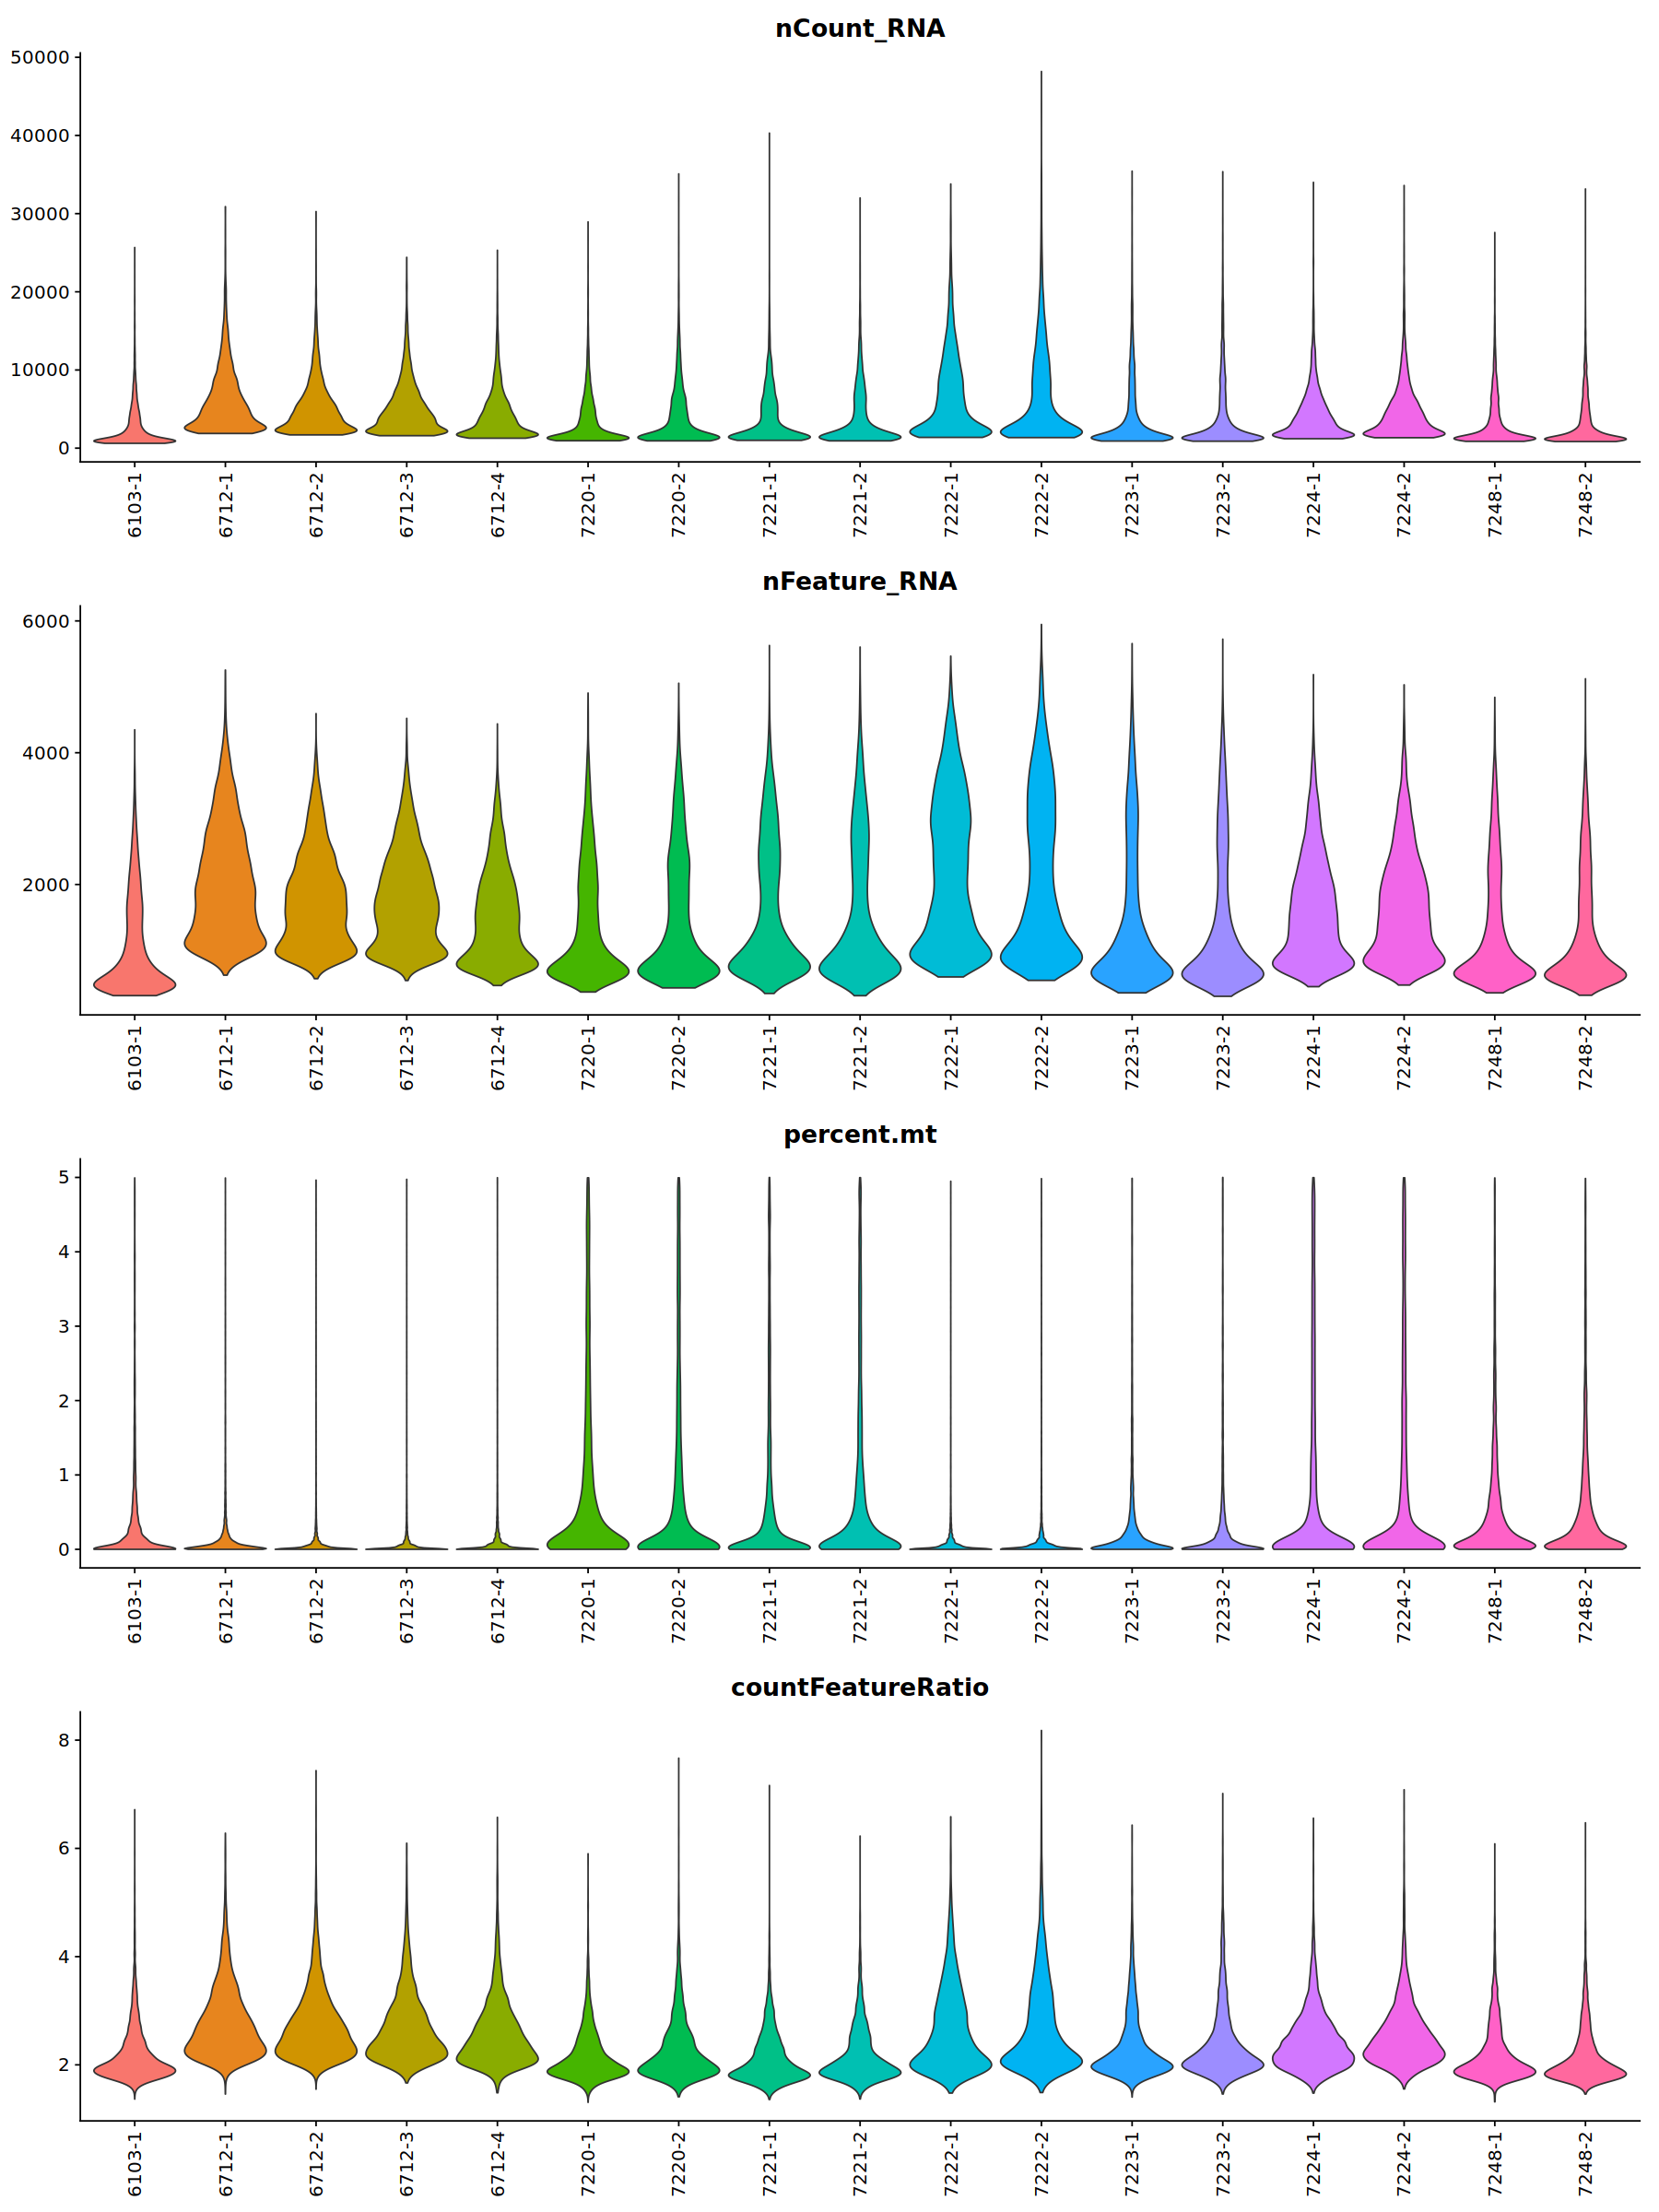

In [10]:
Idents(seurat) = "libId"
options(repr.plot.width=15, repr.plot.height=20)
print(plot_grid(
    plotlist = lapply(c("nCount_RNA", "nFeature_RNA", "percent.mt", "countFeatureRatio"), function(x) {
        p = VlnPlot(seurat, features=x, pt.size=0) + 
            theme(axis.text.x=element_text(vjust=0.5, hjust=0.5, angle=90), axis.title.x = element_blank()) +
            guides(fill=FALSE)
        return(p)
    }), 
    ncol=1, align="hv", axis="tblr"
))

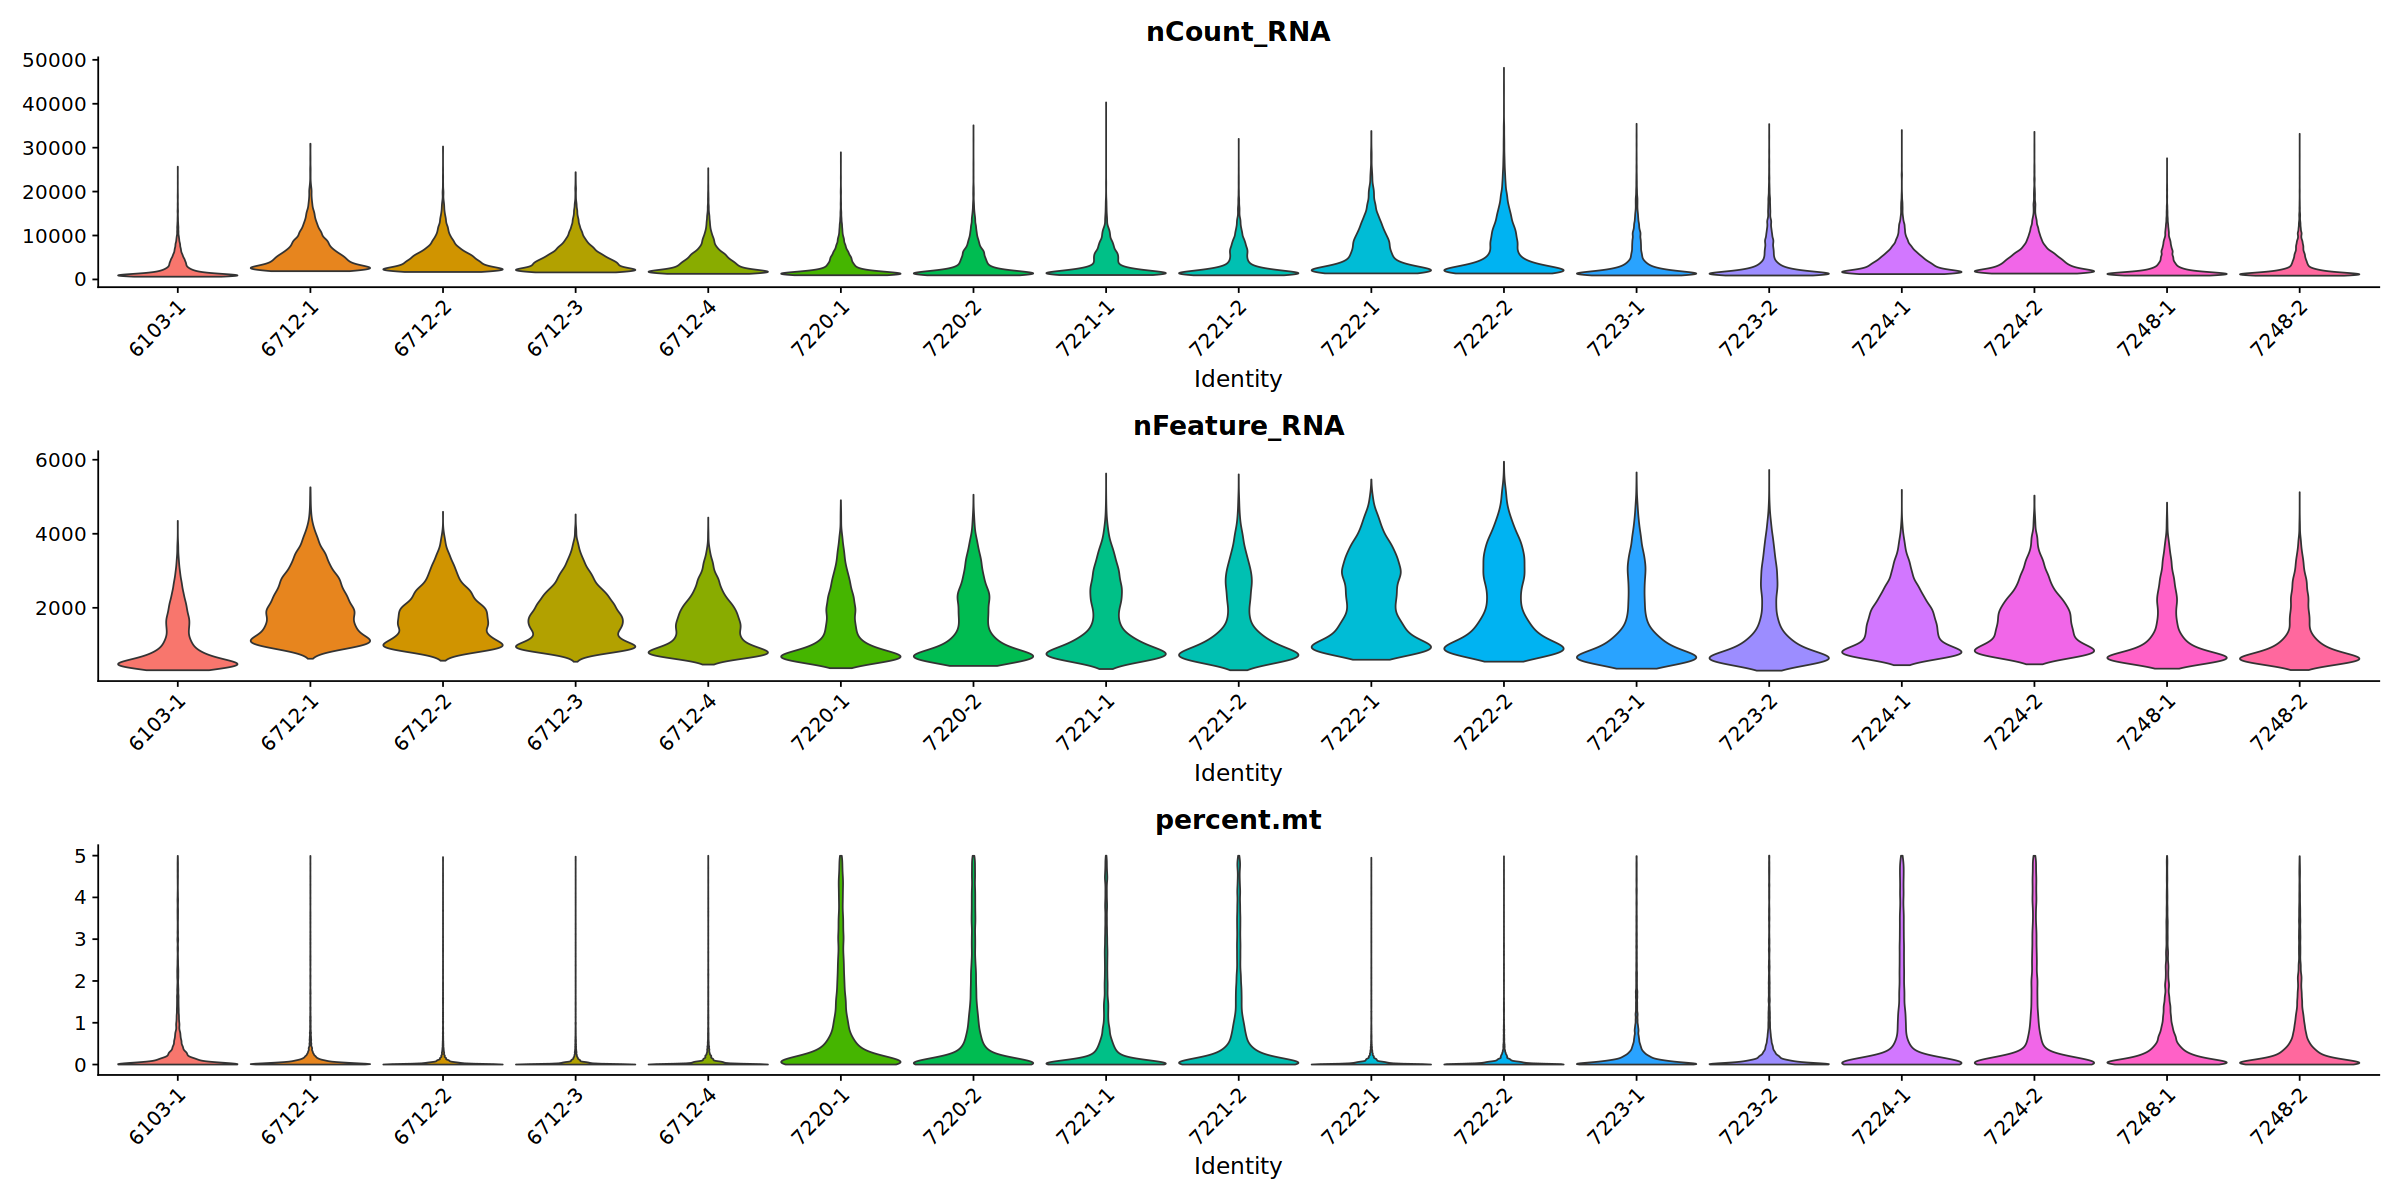

In [11]:
options(repr.plot.width=20, repr.plot.height=10)
Idents(seurat) = "libId"
VlnPlot(seurat, features=c("nCount_RNA", "nFeature_RNA", "percent.mt"), pt.size=0, ncol=1)


In [12]:
seurat

An object of class Seurat 
21680 features across 116934 samples within 1 assay 
Active assay: RNA (21680 features, 0 variable features)

In [13]:
#更正后mt正确版本
saveRDS(seurat,'/home/liuyx/liuyuxuan/spa_seurat/cla/macaca/sn_0821_renew_batch3_all/batch_normalize_renew_1031/renew_fil_data_nFeature300_MT5/macaca_snrna_all_soupX_fil_batch1_0425_1031.rds')



In [14]:
head(seurat@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,group,libId,sampleId,percent.mt,countFeatureRatio
,<chr>,<dbl>,<int>,<chr>,<fct>,<fct>,<dbl>,<dbl>
6103-1_CELL148_N3,SeuratProject,7489,2578,6103-1,6103-1,Cla-rostral,0.41394045,2.904965
6103-1_CELL538_N2,SeuratProject,12053,3101,6103-1,6103-1,Cla-rostral,0.00000000,3.886811
6103-1_CELL6244_N1,SeuratProject,819,475,6103-1,6103-1,Cla-rostral,1.58730159,1.724211
6103-1_CELL559_N2,SeuratProject,2239,1049,6103-1,6103-1,Cla-rostral,0.08932559,2.134414
6103-1_CELL6281_N1,SeuratProject,824,479,6103-1,6103-1,Cla-rostral,0.00000000,1.720251
6103-1_CELL2198_N1,SeuratProject,3935,1647,6103-1,6103-1,Cla-rostral,0.00000000,2.389192


In [ ]:
# Do sct together
seurat = SCTransform(
    seurat, assay="RNA",
    ncells=ncol(seurat[["RNA"]]), 
    variable.features.n=5000,
#         vars.to.regress="percent.mt",
    return.only.var.genes = T,
    method="glmGamPoi"
) 
seurat = seurat %>%
    RunPCA(npcs=100, verbose = FALSE) %>%
    FindNeighbors(dims = 1:50) %>%
    FindClusters(verbose = FALSE) %>%
    RunUMAP(dims = 1:50)
options(repr.plot.width=6, repr.plot.height=2.5)
ElbowPlot(seurat, reduction = "pca", ndims=50)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 20654 by 135838

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 135838 cells



  |                                                                      |   0%

In [3]:
seurat=readRDS('/home/liuyx/liuyuxuan/spa_seurat/cla/renew_data0425/sn_rna_data/snrna_matrix_20230420/sum_data/maca/macaca_snrna_all_soupX_unfil_0425_sct.rds')





Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



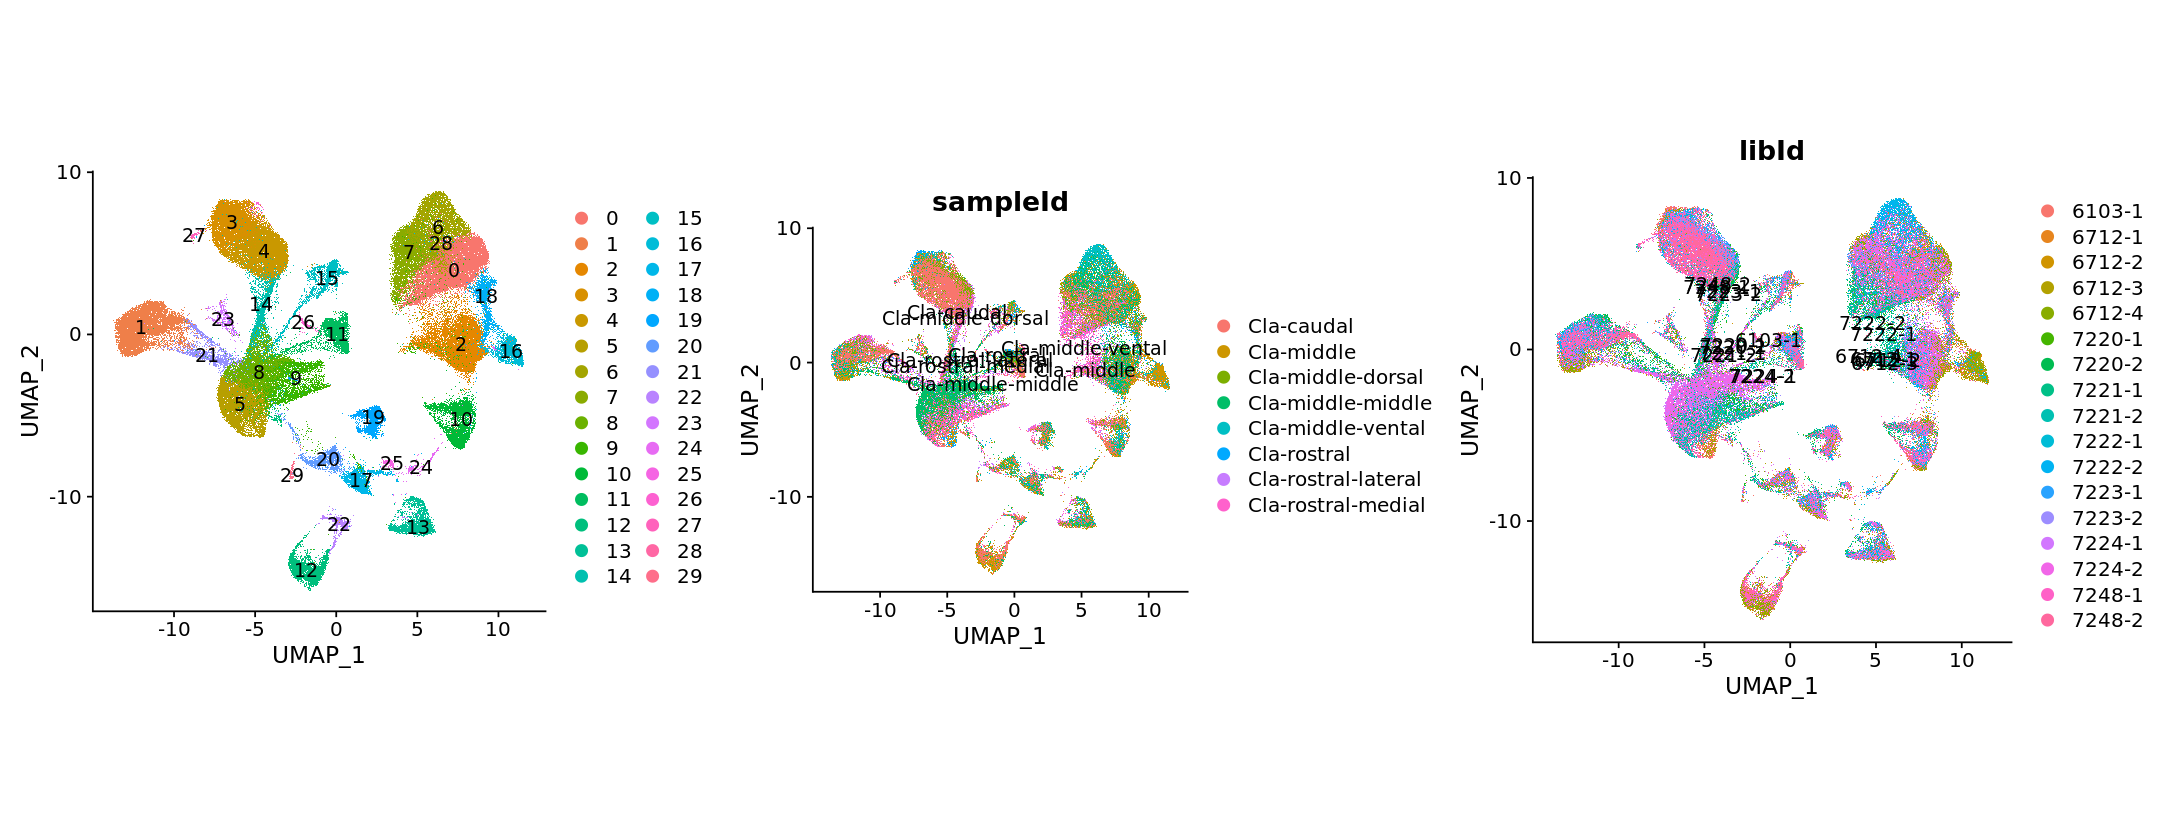

In [4]:
options(repr.plot.width=18, repr.plot.height=7)
plot_grid(
    DimPlot(seurat, reduction="umap", label=T)+coord_fixed(),
    DimPlot(seurat, reduction="umap", group.by="sampleId", label=T)+coord_fixed(),
    DimPlot(seurat, reduction="umap", group.by="libId", label=T)+coord_fixed(),
    nrow=1
)

In [7]:
seurat$species='MQ279R'
seurat@meta.data[grep('6103',seurat@meta.data$libId),]$species='MQC286R'
seurat@meta.data[grep('6712',seurat@meta.data$libId),]$species='MQC286R'

table(seurat$species)


 MQ279R MQC286R 
  97090   38748 

In [9]:
table(seurat@meta.data[seurat@meta.data$species=='MQ279R',]$libId)


6103-1 6712-1 6712-2 6712-3 6712-4 7220-1 7220-2 7221-1 7221-2 7222-1 7222-2 
     0      0      0      0      0   8282   8010   8291   8334   7556   7602 
7223-1 7223-2 7224-1 7224-2 7248-1 7248-2 
  8079   8013   8291   8247   8164   8221 

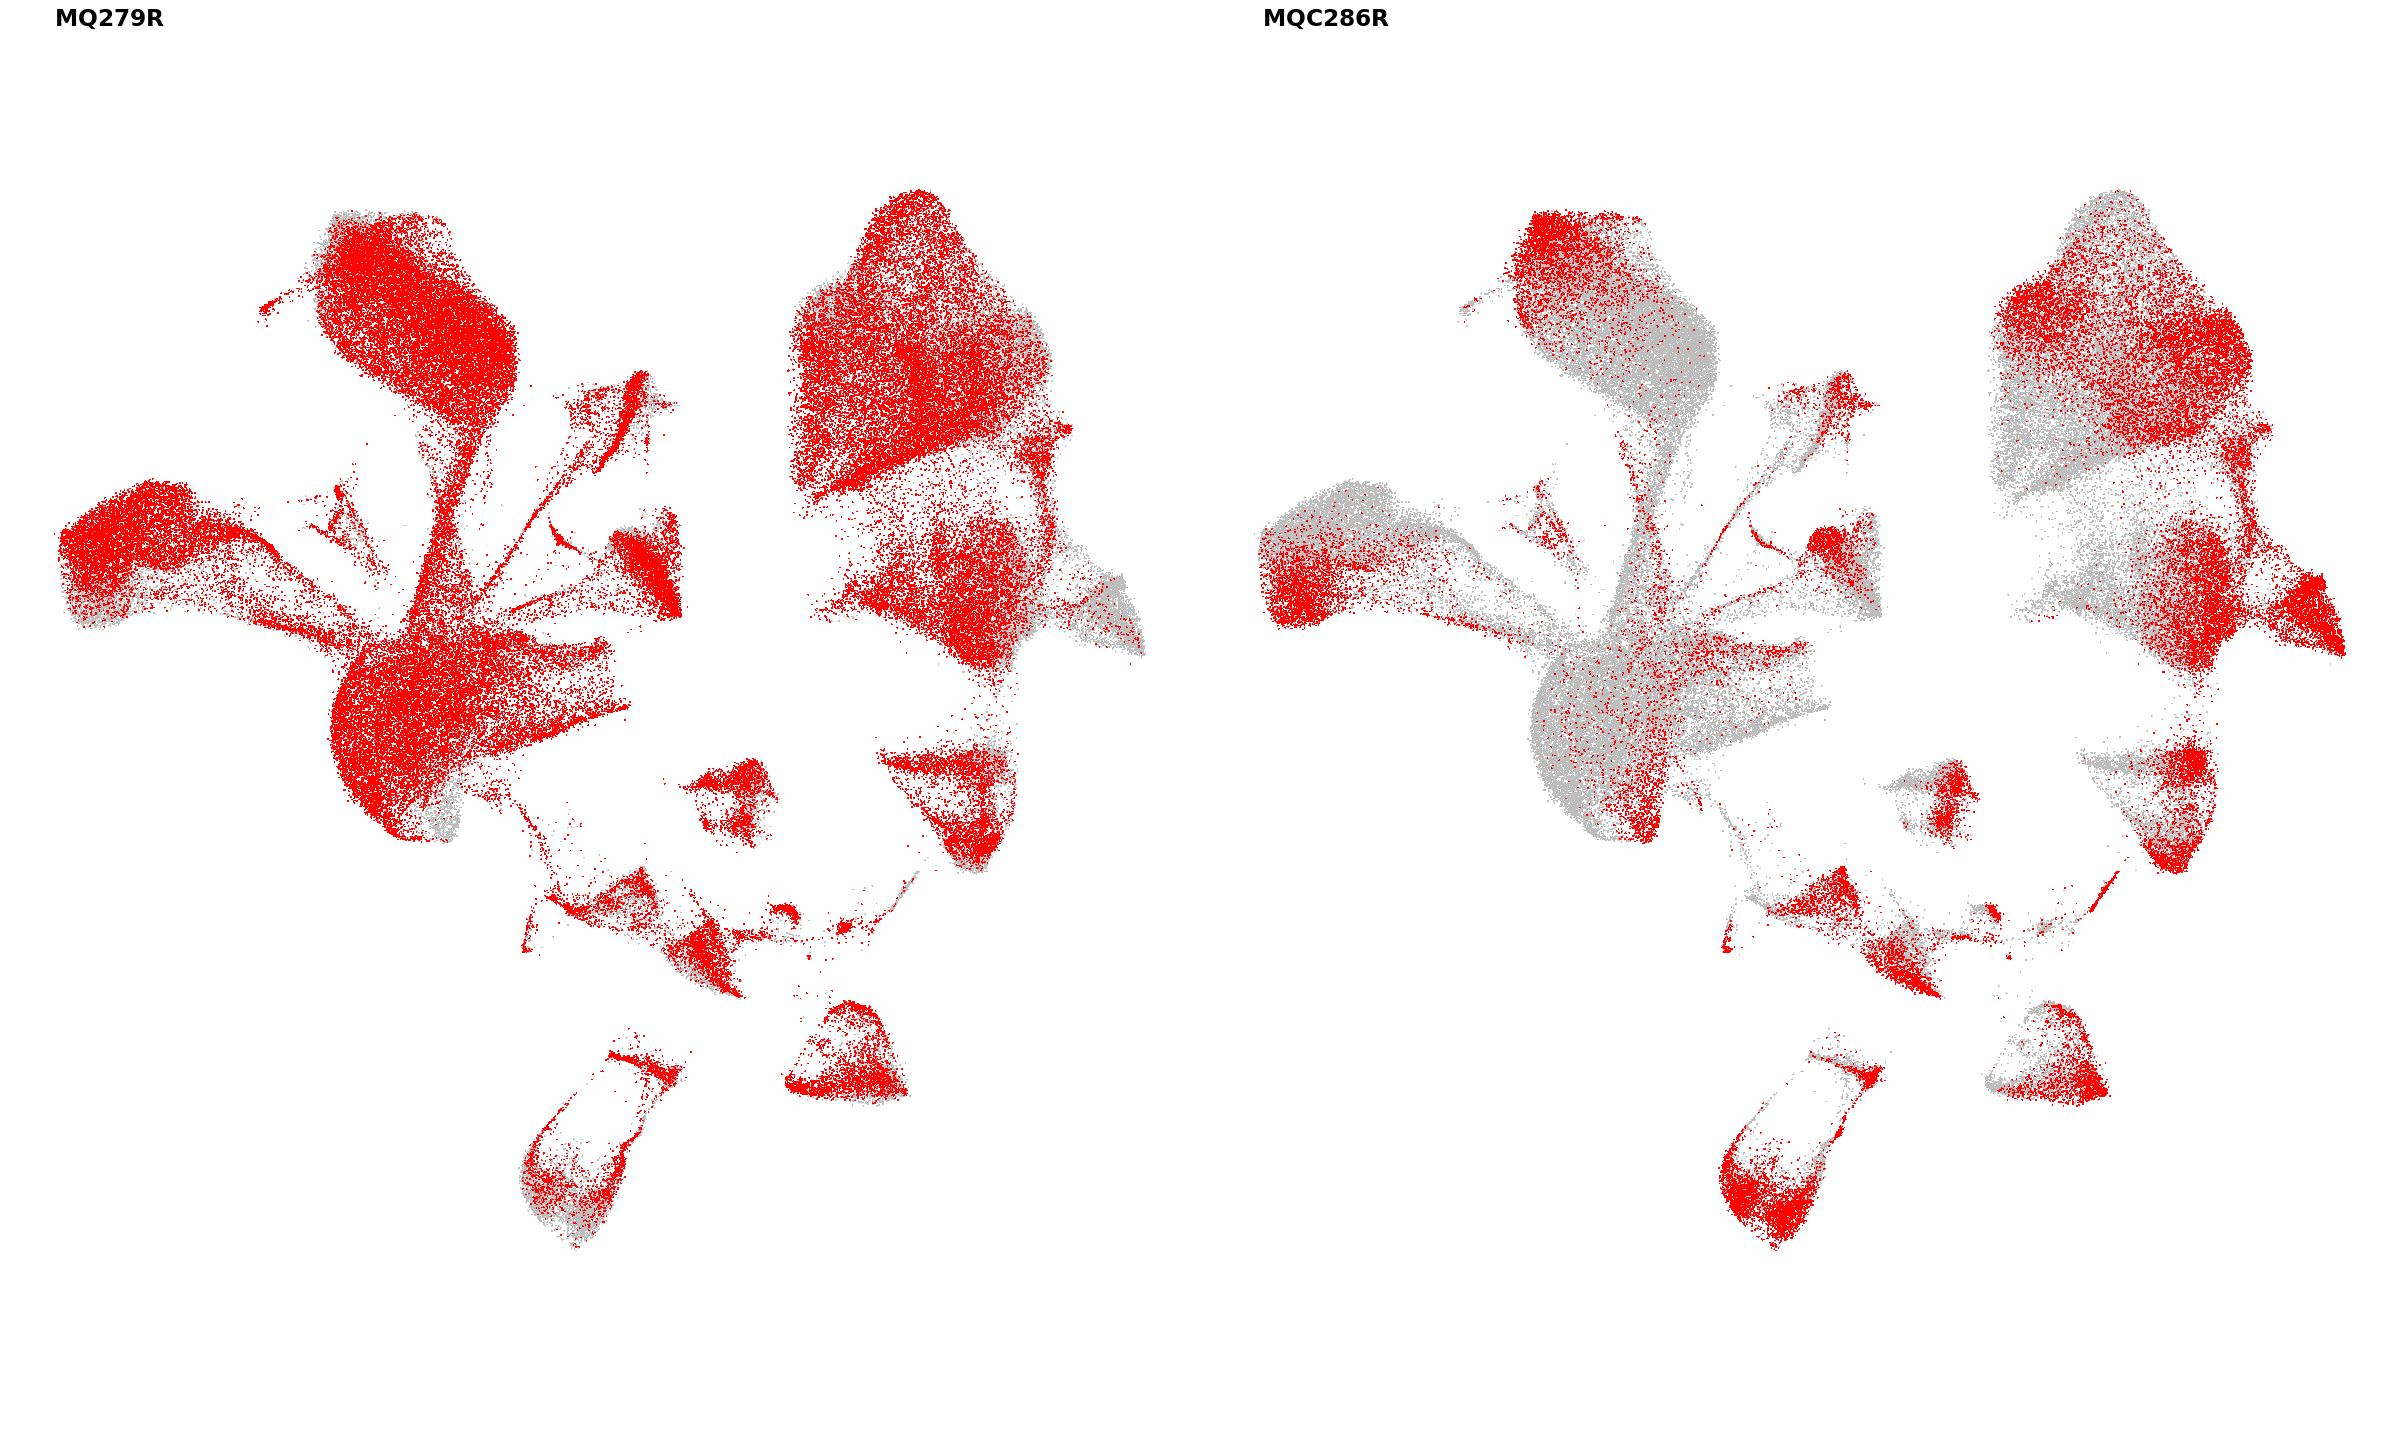

In [10]:
options(repr.plot.width=20, repr.plot.height=12)
myHighlightDimPlot(seurat, highlightBy="species", showAllPoints=T, size=0.2, ncol=as.integer(sqrt(length(unique(seurat$libId))/2)))




In [ ]:
可以
df_text = '''
animal jobid tissue_tag tissue sampleID
MQC286R MQC286R-cla 猕猴屏状核 Cla-rostral 6103-1-220817
MQC286R MQC286R-cla 猕猴屏状核 Cla-rostral 6103-2-220817
MQC286R MQC286R-cla 猕猴屏状核 Cla-rostral 6103-3-220817
MQC286R MQC286R-cla 猕猴屏状核 Cla-rostral 6103-4-220817
MQC286R MQC286R-cla 猕猴屏状核 Cla-rostral 6103-5-220817
MQC286R MQC286R-cla 猕猴屏状核 Cla-rostral 6103-6-220817
MQC286R MQC286R-157 猕猴屏状核 Cla-middle 6712-1-220831
MQC286R MQC286R-157 猕猴屏状核 Cla-middle 6712-2-220831
MQC286R MQC286R-157 猕猴屏状核 Cla-middle 6712-3-220831
MQC286R MQC286R-157 猕猴屏状核 Cla-middle 6712-4-220831



MQ279R MQ279R-004 猕猴屏状核 Cla-rostral-lateral 7220-1-221013
MQ279R MQ279R-004 猕猴屏状核 Cla-rostral-lateral 7220-2-221013
MQ279R MQ279R-005 猕猴屏状核 Cla-rostral-medial 7221-1-221013
MQ279R MQ279R-005 猕猴屏状核 Cla-rostral-medial 7221-2-221013
MQ279R MQ279R-006 猕猴屏状核 Cla-middle-vental 7222-1-221014
MQ279R MQ279R-006 猕猴屏状核 Cla-middle-vental 7222-2-221014
MQ279R MQ279R-007 猕猴屏状核 Cla-middle-dorsal 7223-1-221014
MQ279R MQ279R-007 猕猴屏状核 Cla-middle-dorsal 7223-2-221014
MQ279R MQ279R-008 猕猴屏状核 Cla-middle-middle 7224-1-221014
MQ279R MQ279R-008 猕猴屏状核 Cla-middle-middle 7224-2-221014
MQ279R MQ279R-014 猕猴屏状核 Cla-caudal-dorsal 7230-1-221014
MQ279R MQ279R-014 猕猴屏状核 Cla-caudal-dorsal 7230-2-221014
MQ279R MQ279R-015 猕猴屏状核 Cla-caudal-middle 7231-1-221014
MQ279R MQ279R-015 猕猴屏状核 Cla-caudal-middle 7231-2-221014
MQ279R MQ279R-015 猕猴屏状核 Cla-caudal-middle 7231-3-221014
MQ279R MQ279R-016 猕猴屏状核 Cla-caudal-ventral 7232-1-221014
MQ279R MQ279R-016 猕猴屏状核 Cla-caudal-ventral 7232-2-221014
MQ279R MQ279R-016 猕猴屏状核 Cla-caudal-ventral 7232-3-221014
MQC286R MQC286R-036 猕猴屏状核 Cla-caudal 7248-1-221017
MQC286R MQC286R-036 猕猴屏状核 Cla-caudal 7248-2-221017
'''
tissue_df = pd.read_csv(io.StringIO(df_text), sep='\t')

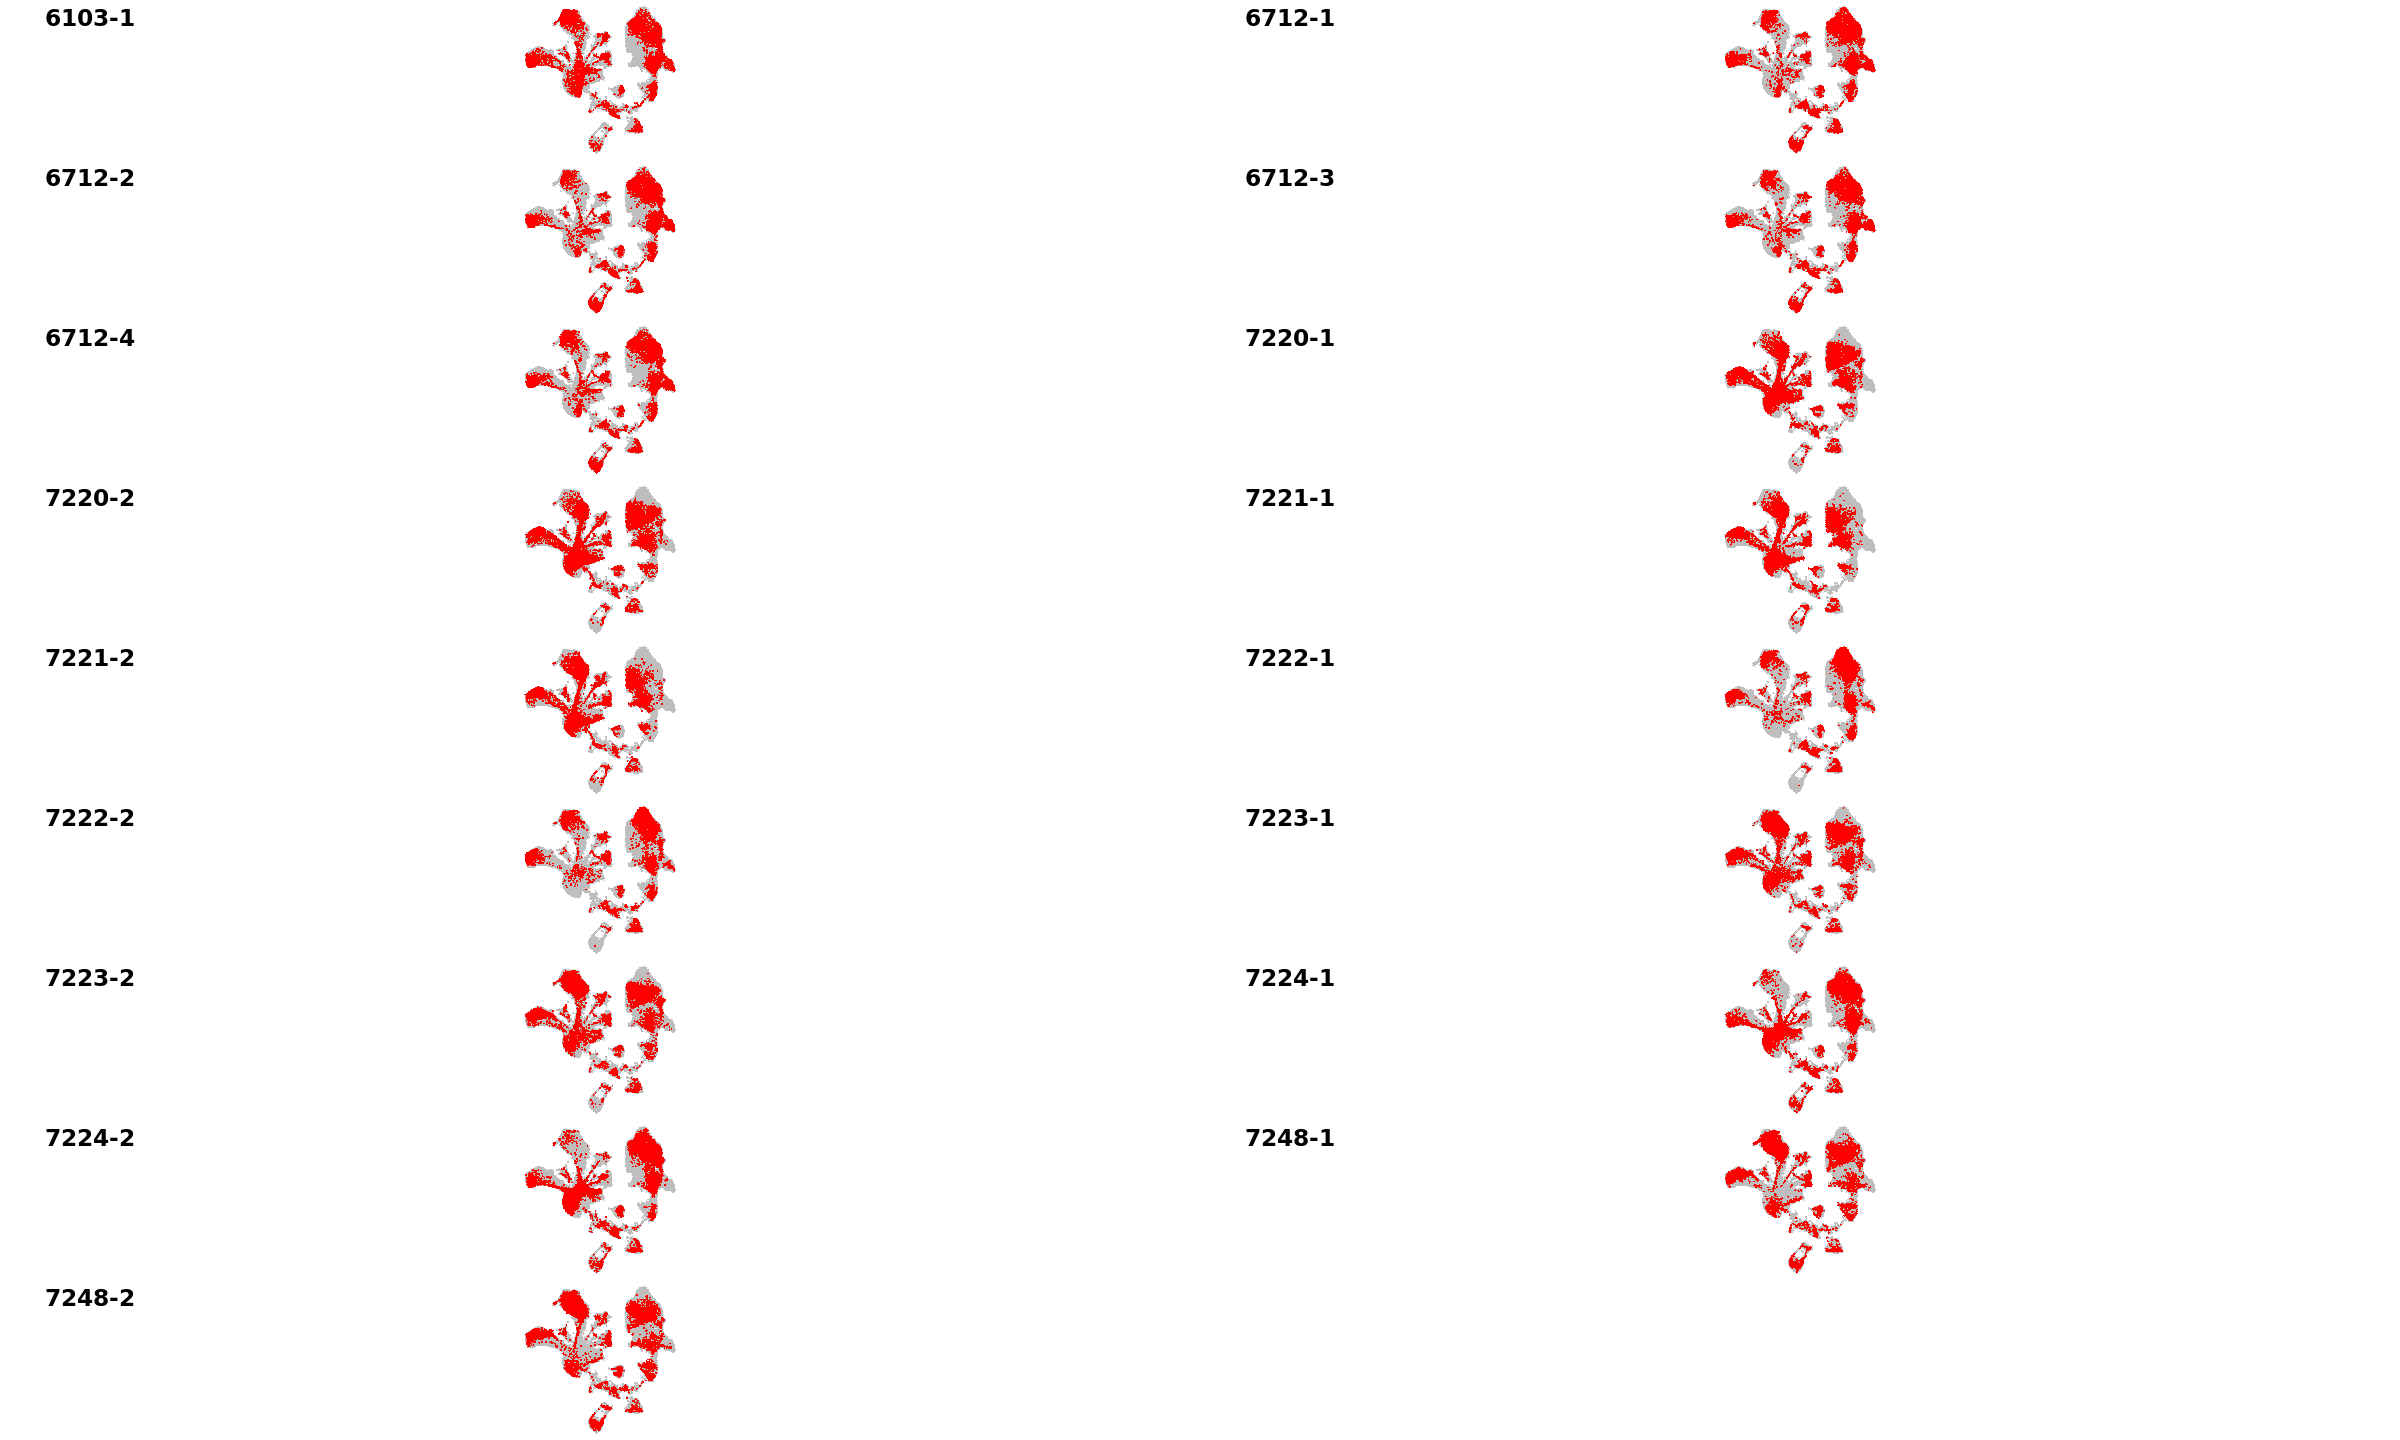

In [5]:
options(repr.plot.width=20, repr.plot.height=12)
myHighlightDimPlot(seurat, highlightBy="libId", showAllPoints=T, size=0.2, ncol=as.integer(sqrt(length(unique(seurat$libId))/2)))




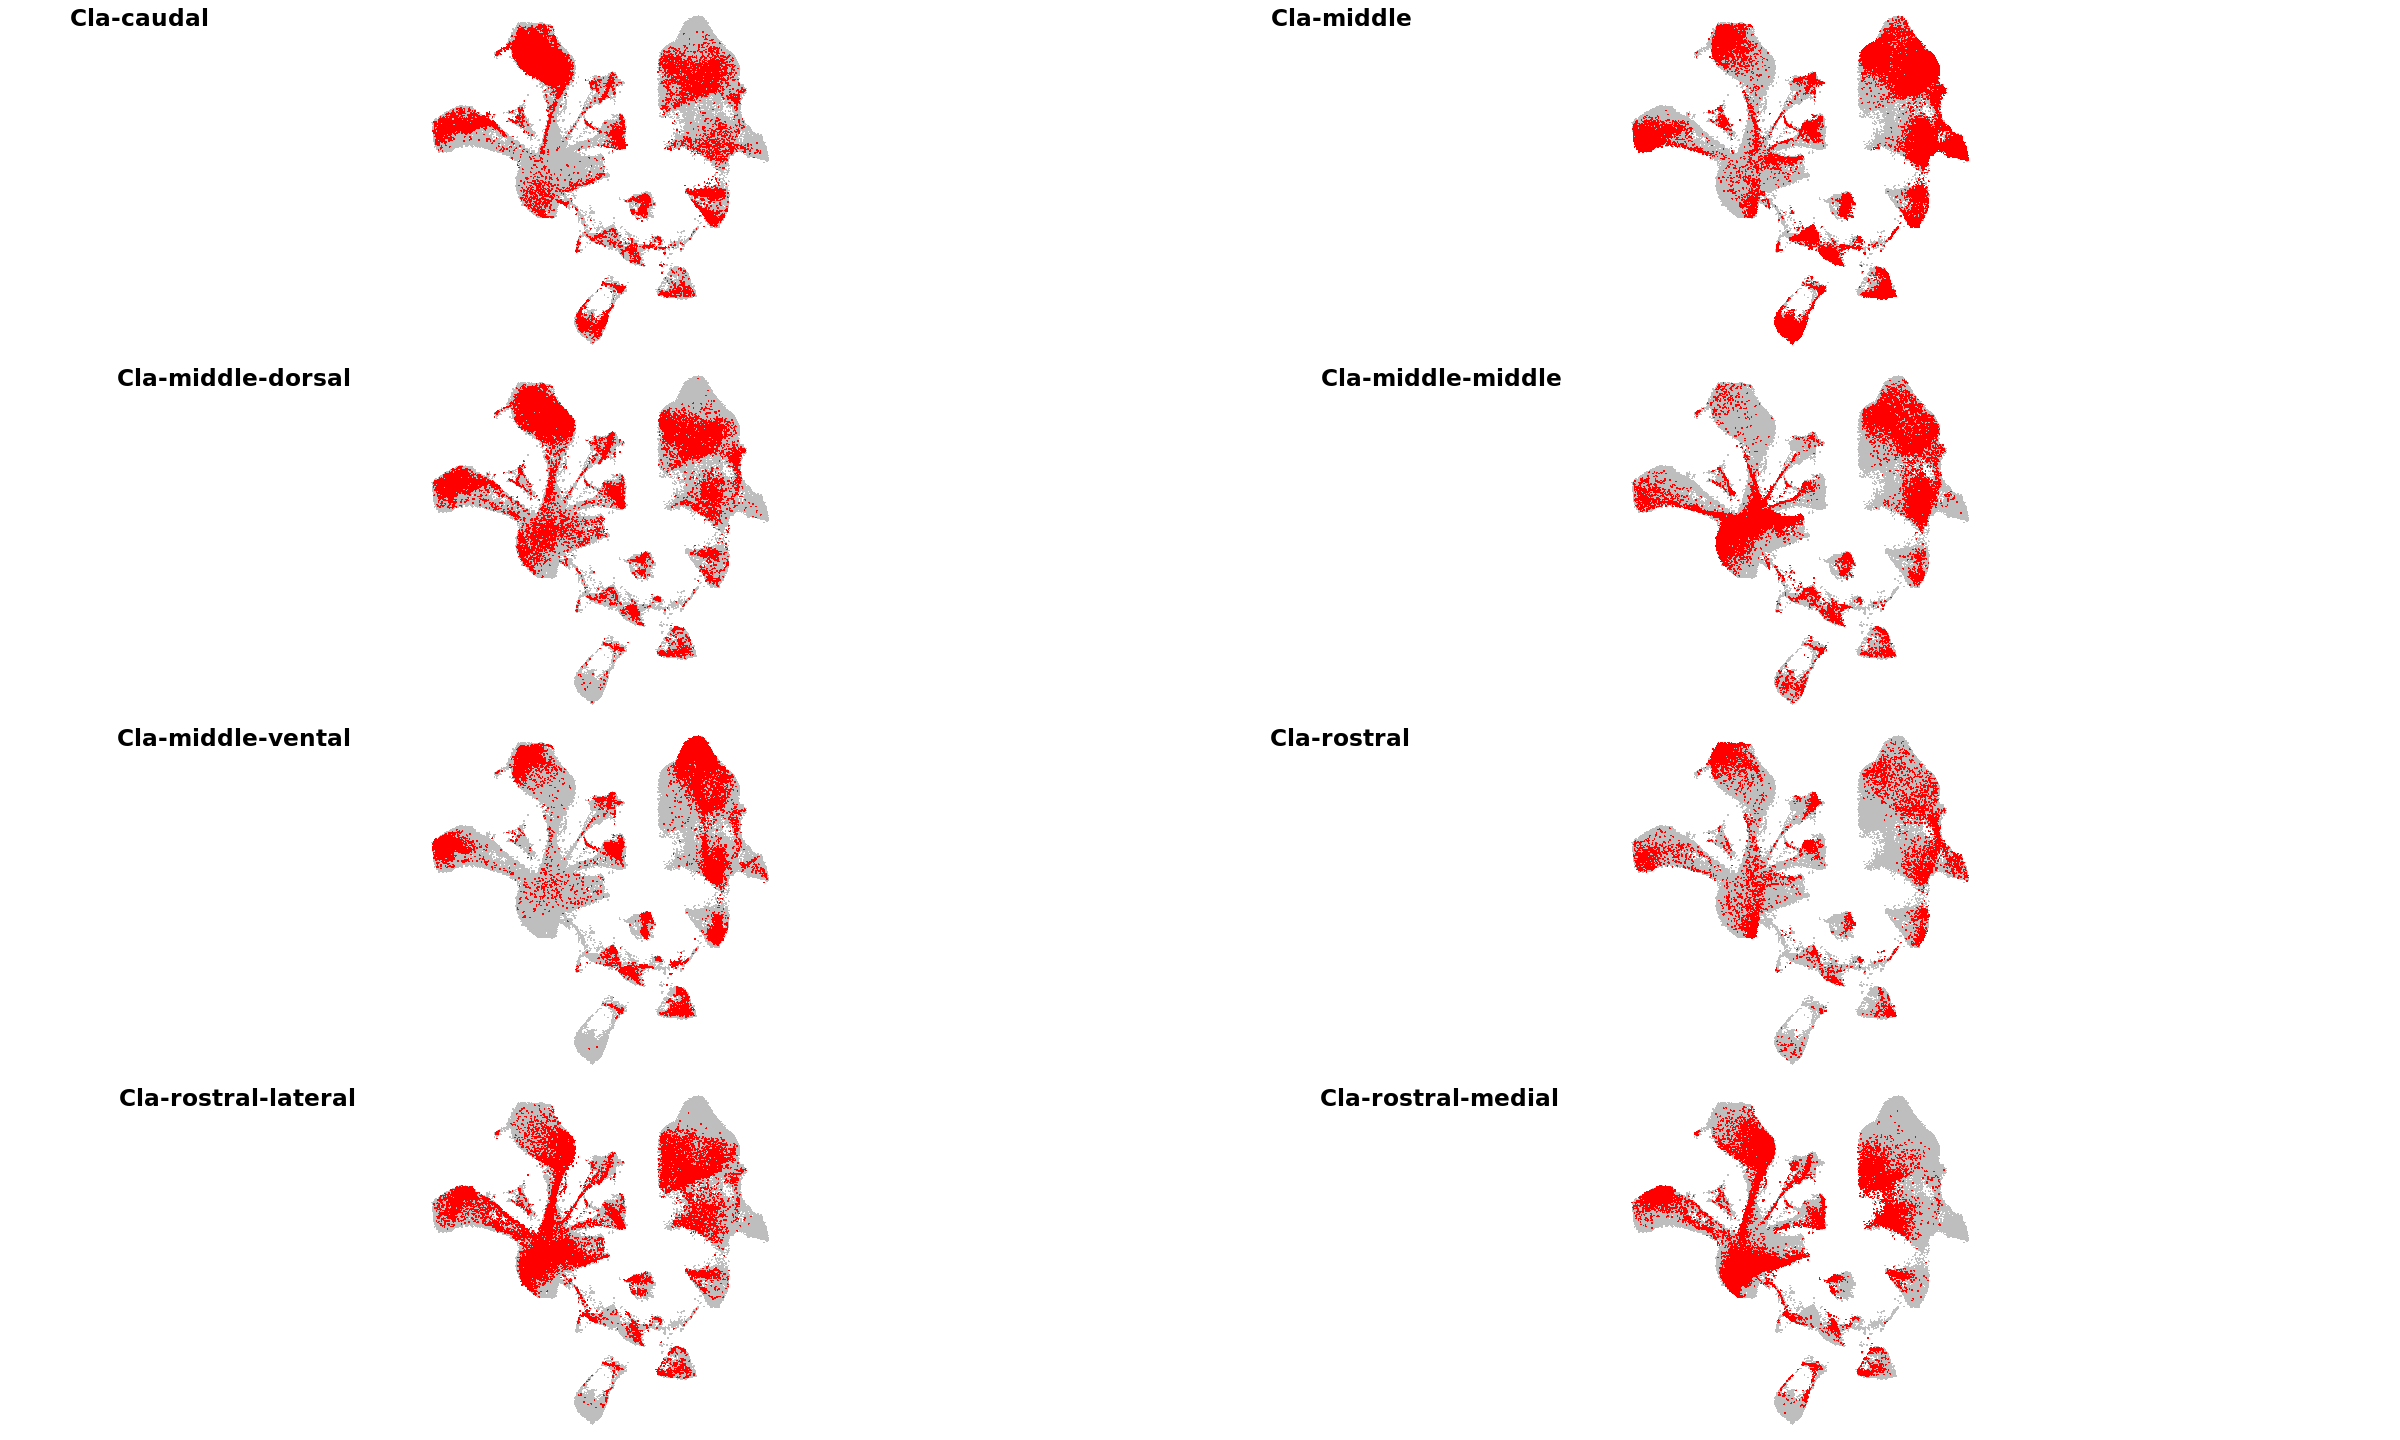

In [4]:
options(repr.plot.width=20, repr.plot.height=12)
myHighlightDimPlot(seurat, highlightBy="sampleId", showAllPoints=T, size=0.2, ncol=as.integer(sqrt(length(unique(seurat$libId))/2)))




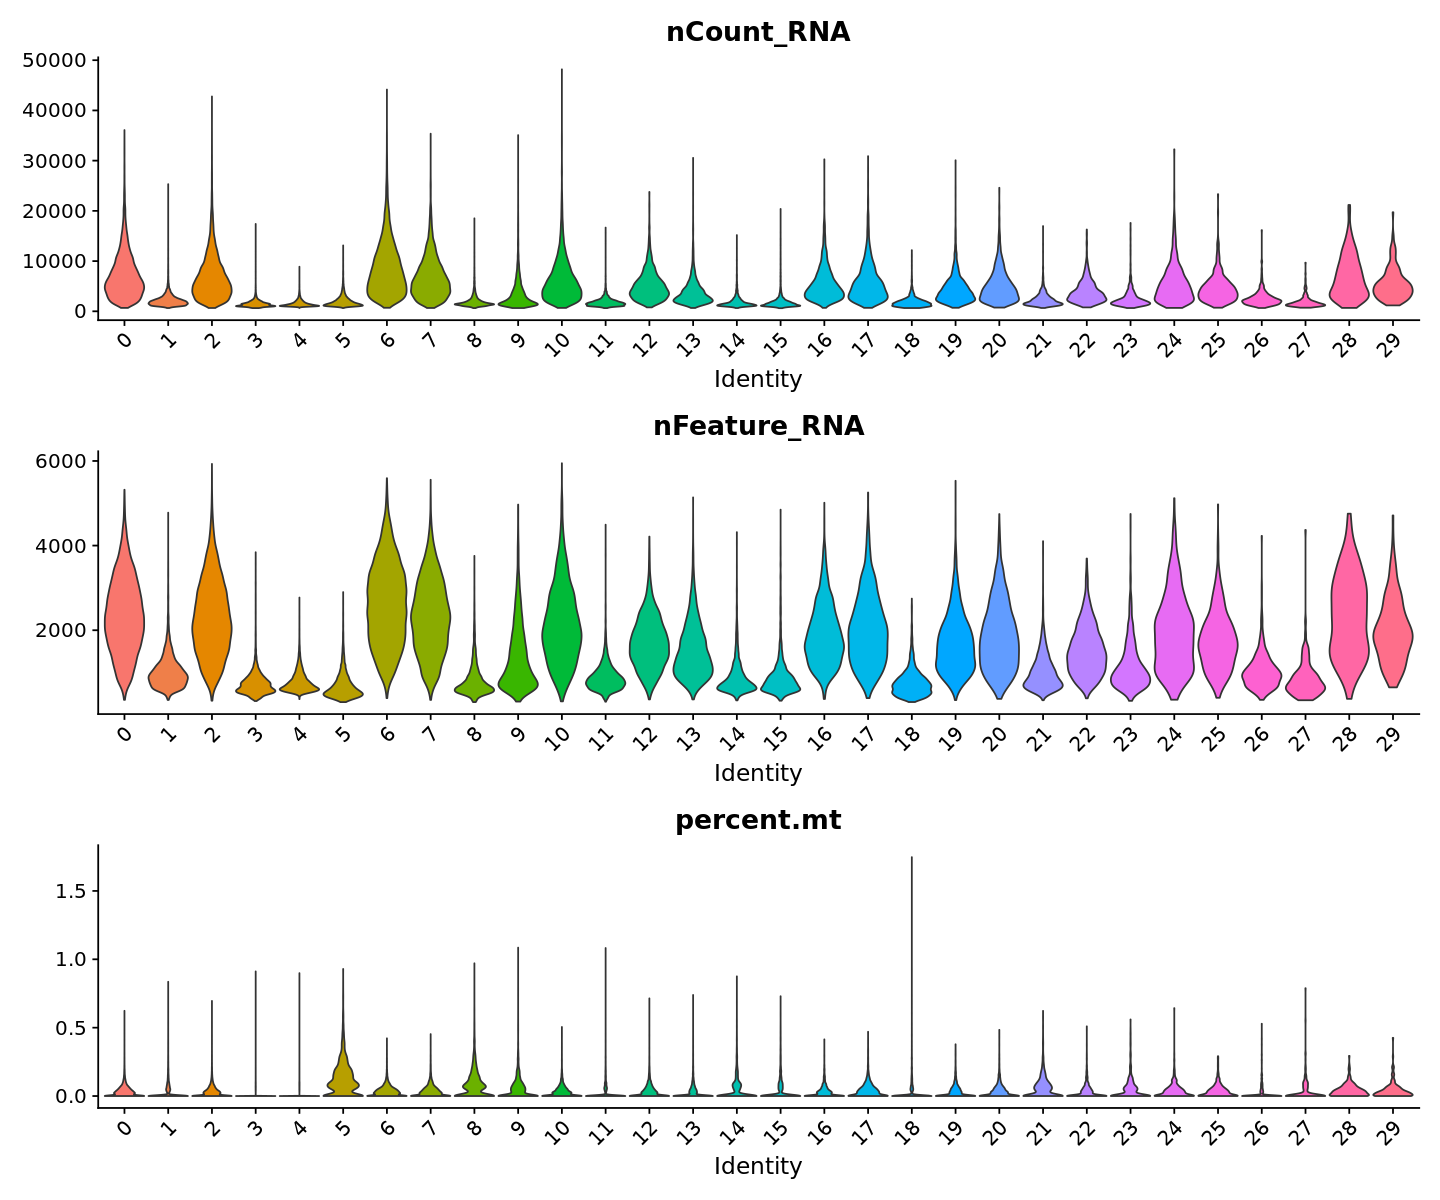

In [5]:
options(repr.plot.width=12, repr.plot.height=10)
Idents(seurat) = "seurat_clusters"
VlnPlot(seurat, features=c("nCount_RNA", "nFeature_RNA", "percent.mt"), pt.size=0, ncol=1)

Warning message in FetchData.Seurat(object = object, vars = features, cells = cells):
"The following requested variables were not found (10 out of 13 shown): DLX6-AS1, AQP4, GJA1, DNAH12, ZMYDN10, IQCG, ALPHA-SMA, PDGFRALPHA, VECAD, CD105"


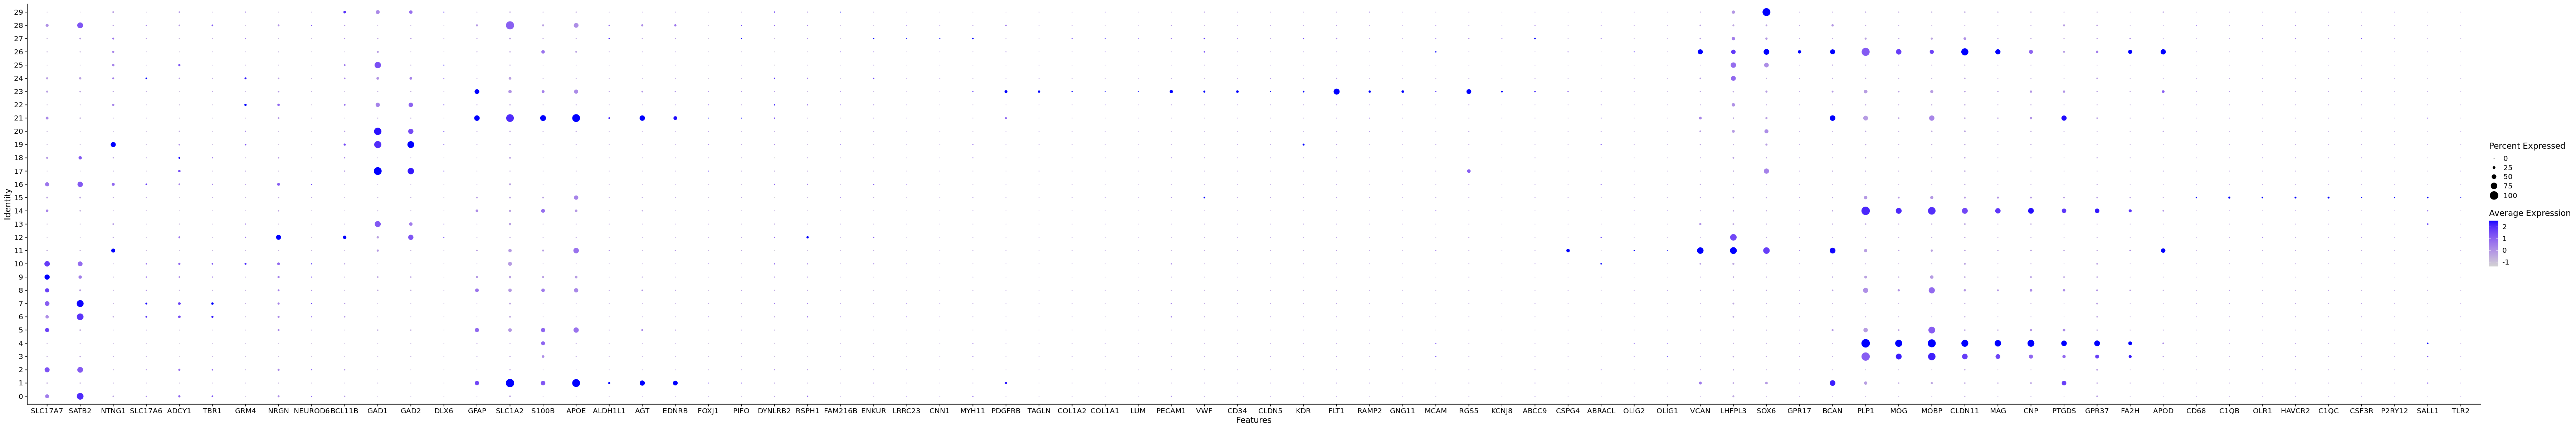

In [7]:
selectMarkers = c(
    "SLC17A7","SATB2",'NTNG1','SLC17A6','ADCY1','TBR1','GRM4','NRGN','NEUROD6','BCL11B', # Excit
    "GAD1", "GAD2",'DLX6','DLX6-AS1', # Inhib,
    "GFAP", "SLC1A2", "SLC1A2", "S100B", "AQP4", "APOE",'GJA1','ALDH1L1','AGT','EDNRB', # Astrocytes
    "FOXJ1", "PIFO", "DYNLRB2", "RSPH1", "DNAH12", "FAM216B", "ZMYDN10", "IQCG", "ENKUR","LRRC23", # Ependymal
    "CNN1", "MYH11", "PDGFRB", "TAGLN", "ALPHA-SMA", # VSMC
    "COL1A2", 'COL1A1','LUM','PDGFRALPHA',# VLMC
    "PECAM1","VWF","CD34","VECAD" ,"CLDN5","KDR","CD105",'FLT1','RAMP2','GNG11',# Endotheial
    "PDGFRB", "MCAM", "RGS5", "ALPHA-SMA", "KCNJ8",'TAGLN','COX4l2','MOTCH3','ABCC9','CSPG4', # Pericytes
    "ABRACL", "PDGFRALPHA", "OLIG2", "CSPG4", "OLIG1", "VCAN",'LHFPL3','SOX6','GPR17','BCAN', # OPC
    "PLP1",'MOG','MOBP','CLDN11','MAG','CNP','PTGDS','GPR37','FA2H','APOD', # Oligo
    'CD68','C1QB','OLR1','HAVCR2','C1QC','CSF3R','CS3CR1','P2RY12','SALL1','TLR2'# Microglia
)

selectMarkers=selectMarkers[!duplicated(selectMarkers)]

options(repr.plot.height=10,repr.plot.width=60)
DotPlot(seurat, features = selectMarkers)




In [8]:
seurat@meta.data$class='Uncertain'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(0,2,6,7,9,10,16,18,28),]$class='Excit_Neuron'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(12,13,17,19,20,22),]$class='Inhibit_Neuron'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(1,21,15),]$class='Astrocytes'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(3,4,14),]$class='Oligo'
#seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(),]$class='Endotheial'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(25,11),]$class='OPC'




In [9]:
table(seurat@meta.data$class)


    Astrocytes   Excit_Neuron Inhibit_Neuron            OPC          Oligo 
         16360          55954          16778           5374          23805 
     Uncertain 
         17567 

In [10]:
table(seurat@meta.data[seurat@meta.data$class=='Uncertain',]$seurat_clusters)



   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
   0    0    0    0    0 8482    0    0 6702    0    0    0    0    0    0    0 
  16   17   18   19   20   21   22   23   24   25   26   27   28   29 
   0    0    0    0    0    0    0  833  633    0  490  246    0  181 

In [11]:
df_test=seurat@reductions$umap@cell.embeddings
df_test=as.data.frame(df_test)
df_test$X=rownames(df_test)

df_meta=seurat@meta.data
df_meta=as.data.frame(df_meta)
df_meta$X=rownames(df_meta)
df_meta=df_meta[,c('nFeature_RNA','X','seurat_clusters')]

df_test=left_join(df_test,df_meta,by='X')




Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



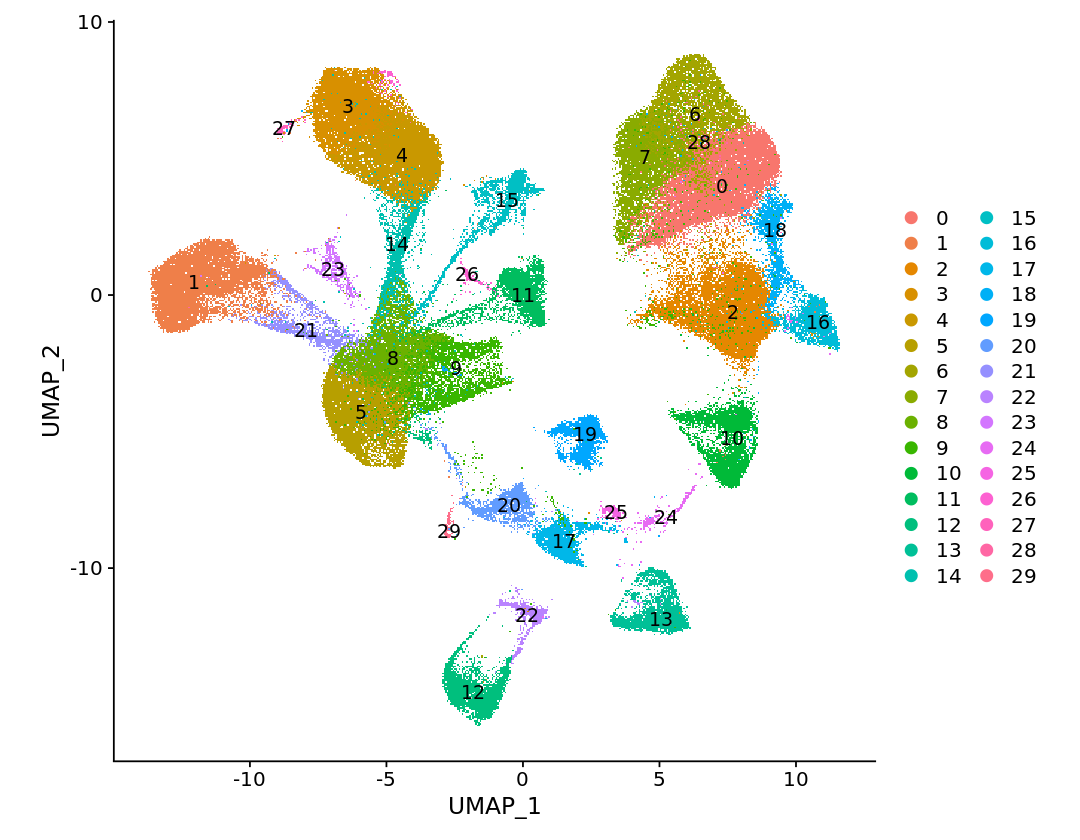

In [12]:
Idents(seurat) = "seurat_clusters"
options(repr.plot.width=9, repr.plot.height=7)
DimPlot(seurat, reduction="umap", label=T)+coord_fixed()


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



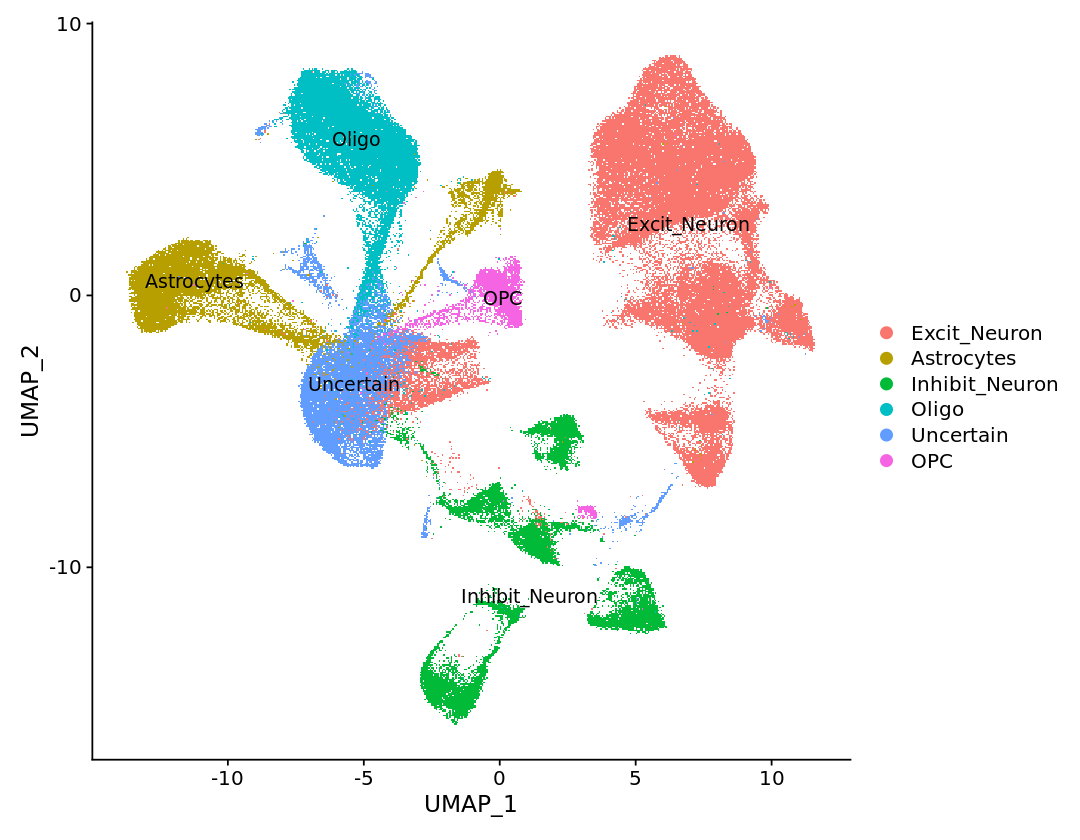

In [13]:
Idents(seurat) = "class"
options(repr.plot.width=9, repr.plot.height=7)
DimPlot(seurat, reduction="umap", label=T)+coord_fixed()

In [14]:
# 每个class抽样80%，最多500个细胞
sampleRatio = 0.8
maxCell = 5000
sampleDf = seurat@meta.data[, c("class"), drop=F]
sampleList = split(sampleDf, sampleDf$class)
sampleList = lapply(sampleList, function(x) {
    sampleSize = as.integer(nrow(x)*0.8)
    if (sampleSize > maxCell) {
        sampleSize = maxCell
    }
    sampleIdx = 1:nrow(x)
    sampleIdx = sample(1:nrow(x), size=sampleSize, replace=F)
    return(x[sampleIdx,,drop=F])
})
sampleDf = Reduce(rbind, sampleList)
str(sampleDf)
table(sampleDf$class)

trainSeurat = seurat[,rownames(sampleDf)]
table(trainSeurat$class)

'data.frame':	29299 obs. of  1 variable:
 $ class: chr  "Astrocytes" "Astrocytes" "Astrocytes" "Astrocytes" ...



    Astrocytes   Excit_Neuron Inhibit_Neuron            OPC          Oligo 
          5000           5000           5000           4299           5000 
     Uncertain 
          5000 


    Astrocytes   Excit_Neuron Inhibit_Neuron            OPC          Oligo 
          5000           5000           5000           4299           5000 
     Uncertain 
          5000 

In [15]:
Idents(trainSeurat) = "class"
classMarker = FindAllMarkers(trainSeurat)
#write_tsv(classMarker, paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.downsample5000ClassMarker.20220822.tsv"))



Calculating cluster Astrocytes

Calculating cluster Excit_Neuron

Calculating cluster Inhibit_Neuron

Calculating cluster OPC

Calculating cluster Oligo

Calculating cluster Uncertain



In [16]:
#classMarker = read_tsv(paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.downsample5000ClassMarker.20220822.tsv"))
classMarker = subset(classMarker, p_val_adj < 0.01 & avg_log2FC > 1)
table(classMarker$cluster)


    Astrocytes   Excit_Neuron Inhibit_Neuron            OPC          Oligo 
            42             27             51             30             87 
     Uncertain 
            60 

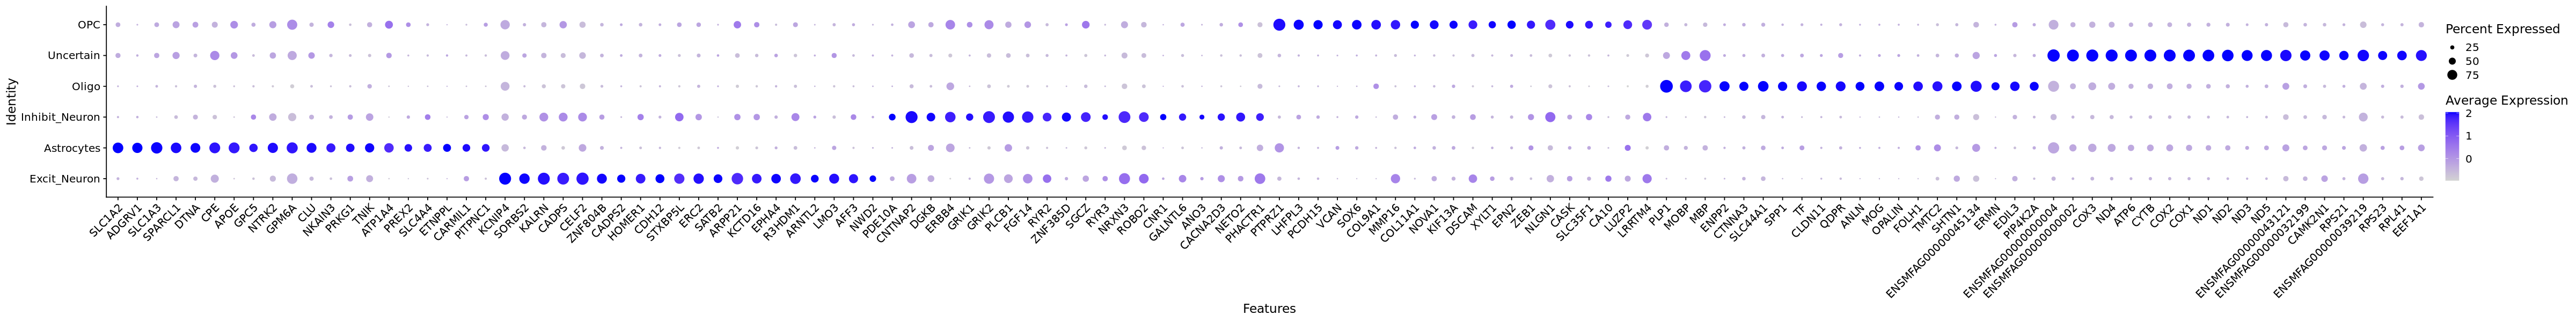

In [17]:

classMarkerTop = classMarker %>% group_by(cluster) %>% top_n(n = 20, wt = avg_log2FC)
options(repr.plot.width=length(unique(classMarkerTop$gene))/3, repr.plot.height=5)
Idents(seurat) = "class"
DotPlot(seurat, features=unique(c(classMarkerTop$gene))) + RotatedAxis()

In [ ]:
trainDf = as.data.frame(t(as.matrix(trainSeurat[["SCT"]]@data[unique(classMarker$gene), ])))
trainDf$class = trainSeurat$class
trainDf = subset(trainDf, class != "Uncertain")
trainDf$class = factor(trainDf$class)
# We need to modify the name of the columns
colnames(trainDf) = paste0("col_", colnames(trainDf))
colnames(trainDf) = gsub("-", "_", colnames(trainDf))

rf = randomForest(col_class~., data=trainDf, ntree=500)
#saveRDS(rf, paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.class.randomForest.20220822.rds"))

 num [1:5, 1:6] 4752 61 16 10 22 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:5] "Astrocytes" "Excit_Neuron" "Inhibit_Neuron" "OPC" ...
  ..$ : chr [1:6] "Astrocytes" "Excit_Neuron" "Inhibit_Neuron" "OPC" ...


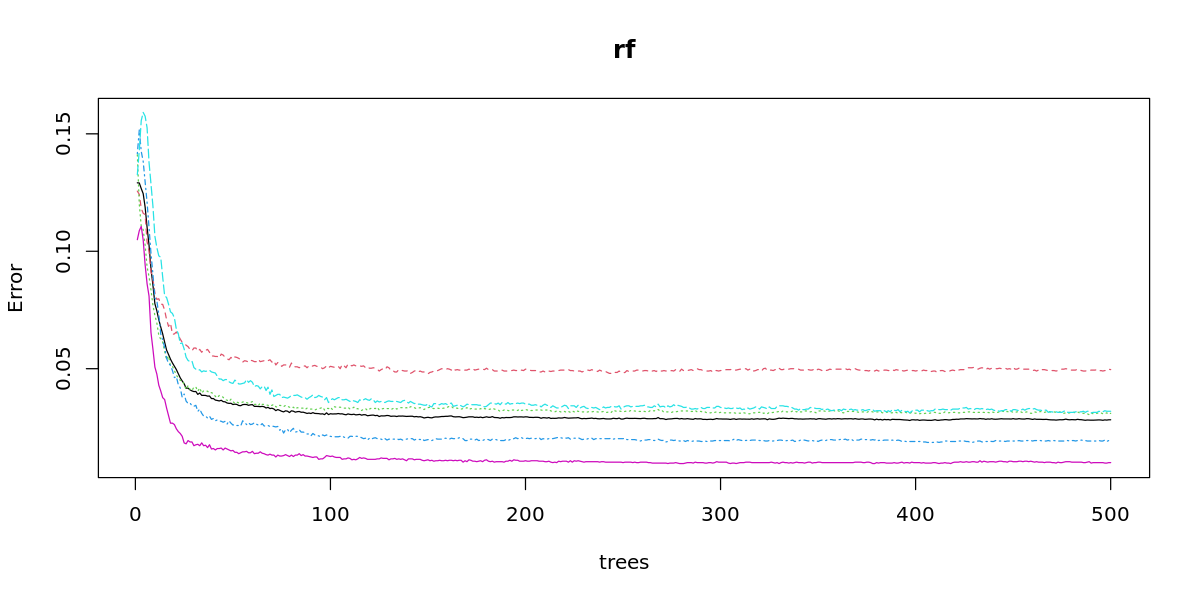

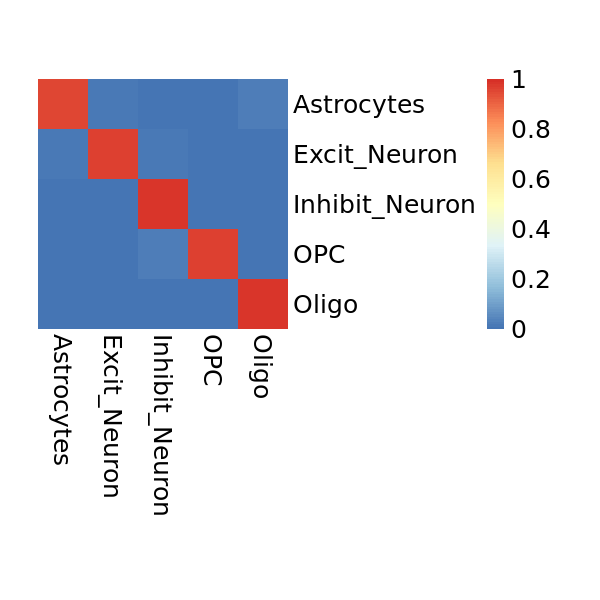

In [26]:
#rf = readRDS(paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.class.randomForest.20220822.rds"))
str(rf$confusion)
options(repr.plot.width=10, repr.plot.height=5)
plot(rf)

confusionRatio = t(apply(rf$confusion[1:5, 1:5], 1, function(x) {x/sum(x)}))
options(repr.plot.width=5, repr.plot.height=5)
pheatmap(confusionRatio, breaks=seq(0,1,0.01), cluster_rows=F, cluster_cols=F, border_color=NA, cellwidth=30, cellheight=30, fontsize=15)

 'matrix' num [1:135838, 1:5] 0.054 0.032 0.768 0.012 0.084 0.014 0.116 0.052 0.026 0.022 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:135838] "6103-1_CELL148_N3" "6103-1_CELL538_N2" "6103-1_CELL6244_N1" "6103-1_CELL559_N2" ...
  ..$ : chr [1:5] "Astrocytes" "Excit_Neuron" "Inhibit_Neuron" "OPC" ...


cellId,maxPredClassScore,maxPredClass
<chr>,<dbl>,<chr>
6103-1_CELL148_N3,0.864,Excit_Neuron
6103-1_CELL538_N2,0.916,Excit_Neuron
6103-1_CELL6244_N1,0.768,Astrocytes
6103-1_CELL559_N2,0.672,Inhibit_Neuron
6103-1_CELL6281_N1,0.766,Oligo
6103-1_CELL2198_N1,0.938,Excit_Neuron


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2180  0.7680  0.9360  0.8416  0.9820  1.0000 

[1] TRUE

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



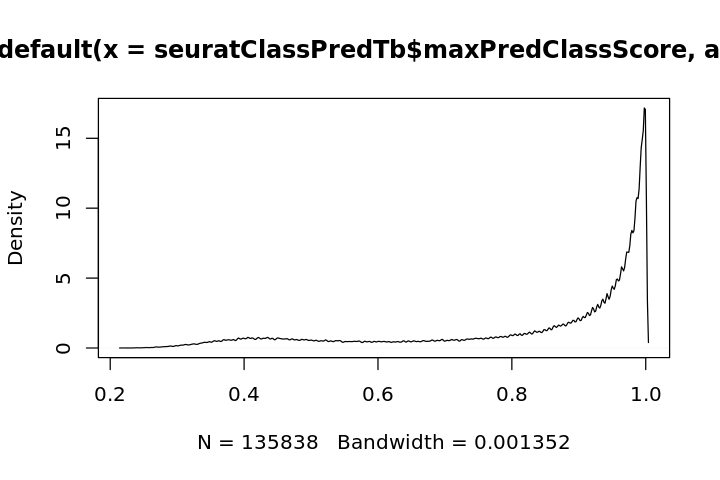

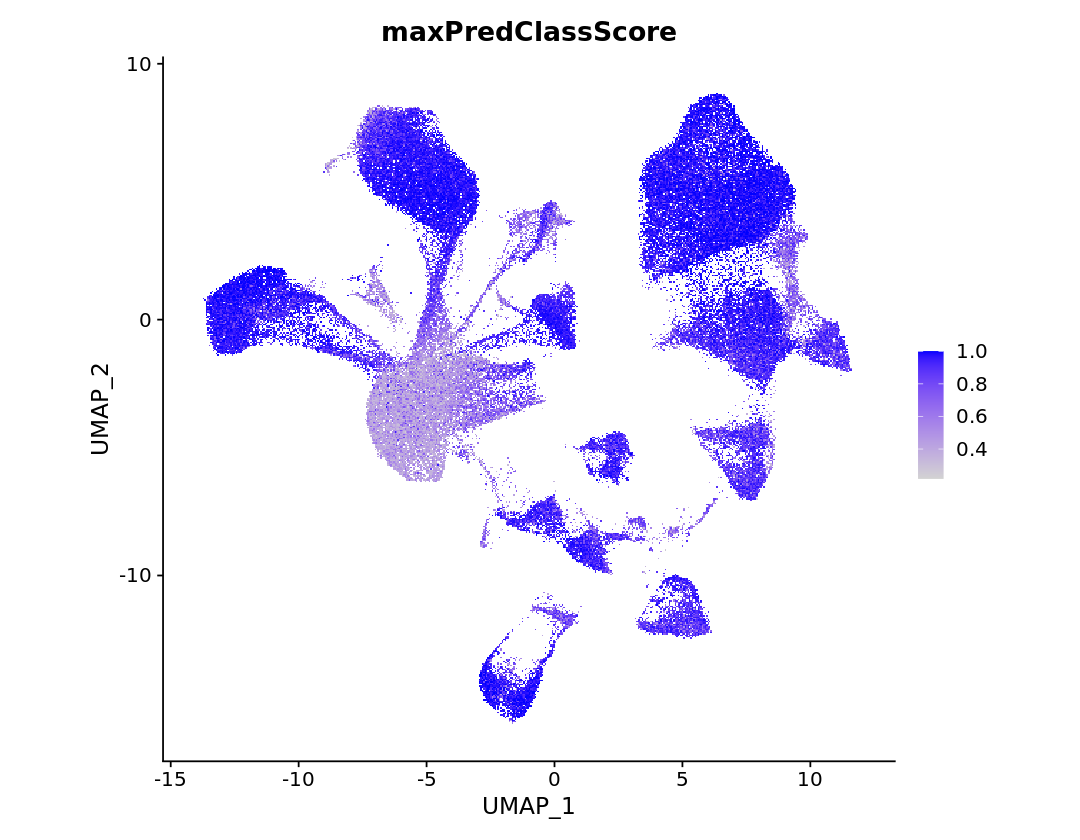

In [27]:
# Apply the trainer to filter cells
seuratCountDf = as.data.frame(t(as.matrix(seurat[["SCT"]]@data[unique(classMarker$gene), ])))
colnames(seuratCountDf) = paste0("col_", colnames(seuratCountDf))
colnames(seuratCountDf) = gsub("-", "_", colnames(seuratCountDf))
seuratClassPred = predict(rf, seuratCountDf, type="prob")
str(seuratClassPred)

seuratClassPredTb = tibble(
    cellId = rownames(seuratClassPred),
    maxPredClassScore = apply(seuratClassPred, 1, max),
    maxPredClass = apply(seuratClassPred, 1, function(x) {names(x)[which.max(x)]})
)
head(seuratClassPredTb)

summary(seuratClassPredTb$maxPredClassScore)
options(repr.plot.width=6, repr.plot.height=4)
plot(density(seuratClassPredTb$maxPredClassScore, adjust=0.1))

identical(seuratClassPredTb$cellId, rownames(seurat@meta.data))
tmpDf = as.data.frame(seuratClassPredTb[c("maxPredClassScore", "maxPredClass")])
rownames(tmpDf) = seuratClassPredTb$cellId

seurat = AddMetaData(seurat, tmpDf)

options(repr.plot.width=9, repr.plot.height=7)
FeaturePlot(seurat, reduction="umap", features="maxPredClassScore")+coord_fixed()

In [24]:
# Filter class outliers
# Removed clusters classified with ambiguous labels
# Removed cells classified with a different label from the majority of cells in its clusters
# Removed outliers when clustering, typically on the fringes of clusters in U-map space

Idents(seurat) = "seurat_clusters"
cellNum0 = ncol(seurat)
classFiltSeurat = subset(seurat, maxPredClassScore >= 0.8)
cellNum1 = ncol(classFiltSeurat)
message("Filt cell ratio: ", cellNum1/cellNum0)



Filt cell ratio: 0.726313697198133



In [23]:
table(classFiltSeurat$maxPredClass)


    Astrocytes   Excit_Neuron Inhibit_Neuron            OPC          Oligo 
         13589          45424          13694           4944          21010 

In [28]:
#过滤800

#过滤nFeature<800的EX及IN
df_fil=classFiltSeurat@meta.data
EX_cell=rownames(df_fil[df_fil$nFeature_RNA > 800 & df_fil$maxPredClass=='Excit_Neuron',])
IN_cell=rownames(df_fil[df_fil$nFeature_RNA > 800 & df_fil$maxPredClass=='Inhibit_Neuron',])
Other_cell=rownames(df_fil[df_fil$maxPredClass %in% setdiff(unique(df_fil$maxPredClass),c('Excit_Neuron','Inhibit_Neuron')),])
fil_cell=c(EX_cell,IN_cell,Other_cell)

classFiltSeurat=subset(classFiltSeurat,cells = fil_cell)




In [29]:
table(classFiltSeurat$maxPredClass)


    Astrocytes   Excit_Neuron Inhibit_Neuron            OPC          Oligo 
         13589          44450          13269           4944          21010 

In [30]:
saveRDS(classFiltSeurat,'/home/liuyx/liuyuxuan/spa_seurat/cla/renew_data0425/sn_rna_data/snrna_matrix_20230420/sum_data/maca/macaca_snrna_all_soupX_RFfil_0425.rds')





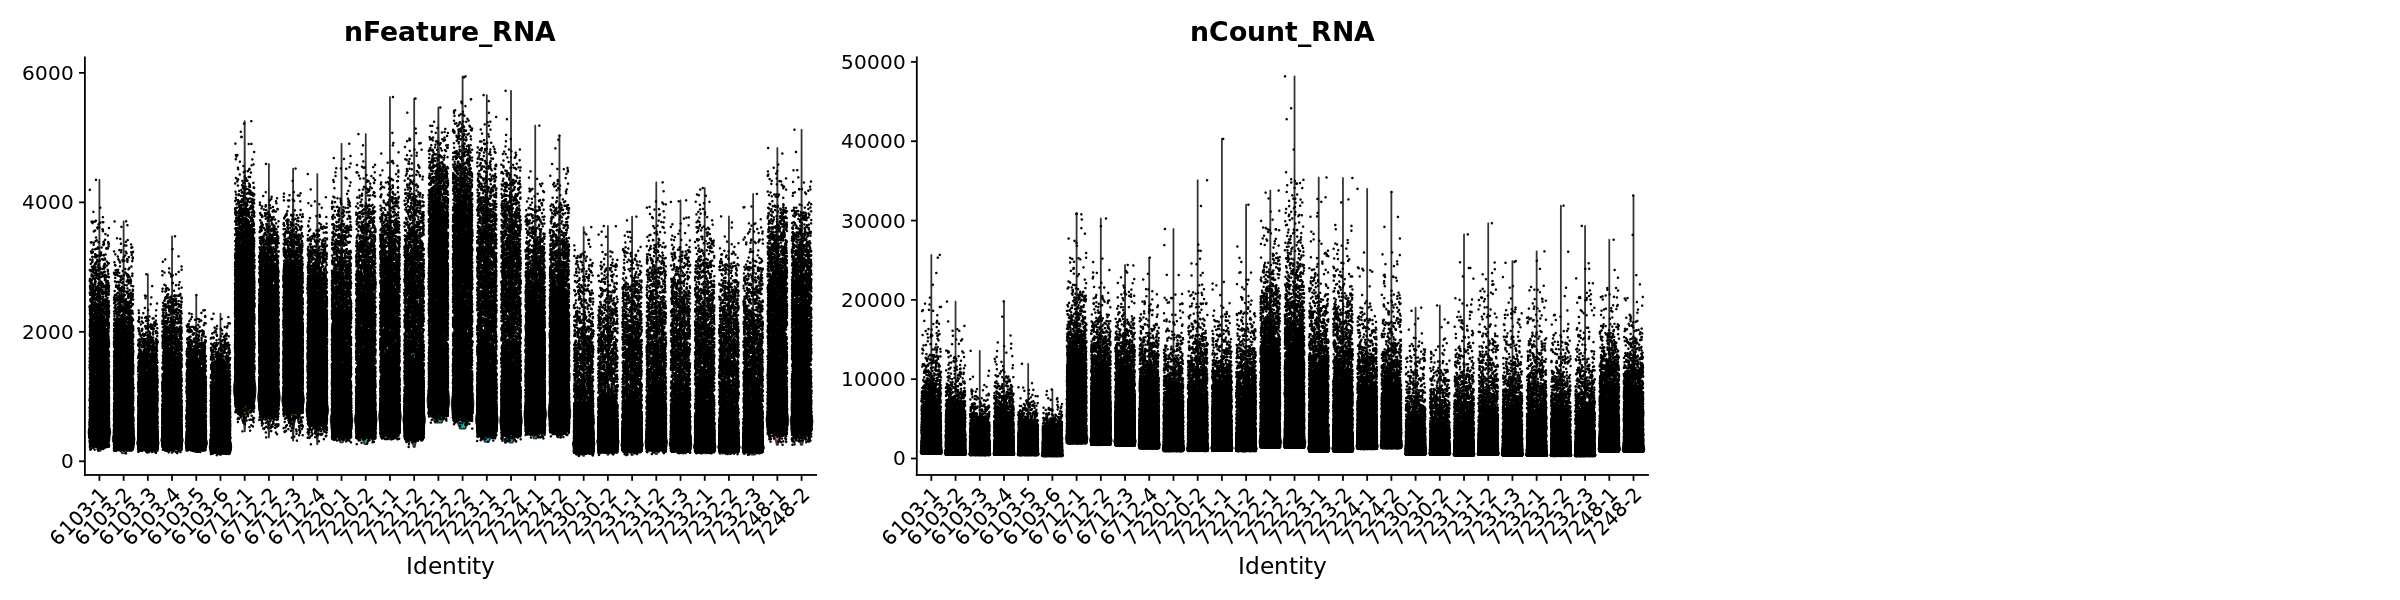

In [3]:
options(repr.plot.height=5,repr.plot.width=20)
# Visualize QC metrics as a violin plot
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA"), ncol = 3, group.by="group")


Warning message:
"Removed 12709 rows containing non-finite values (stat_ydensity)."


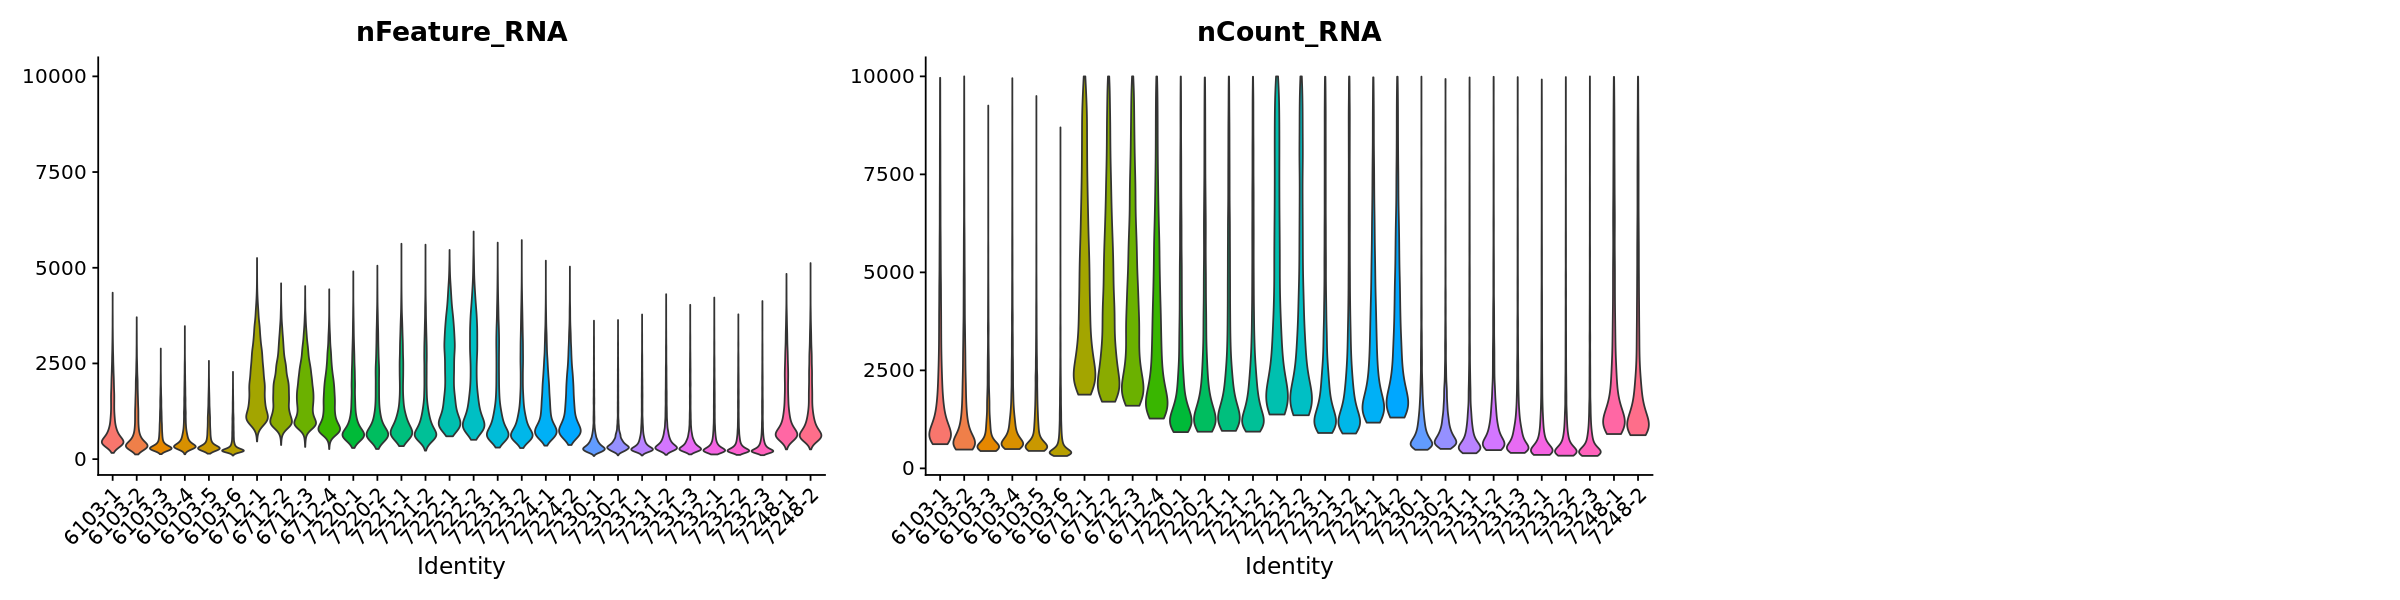

In [5]:
options(repr.plot.height=5,repr.plot.width=20)
# Visualize QC metrics as a violin plot
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA"),pt.size = 0, y.max=10000,ncol = 3, group.by="group")



Warning message:
"Removed 12709 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 112 rows containing non-finite values (stat_ydensity)."


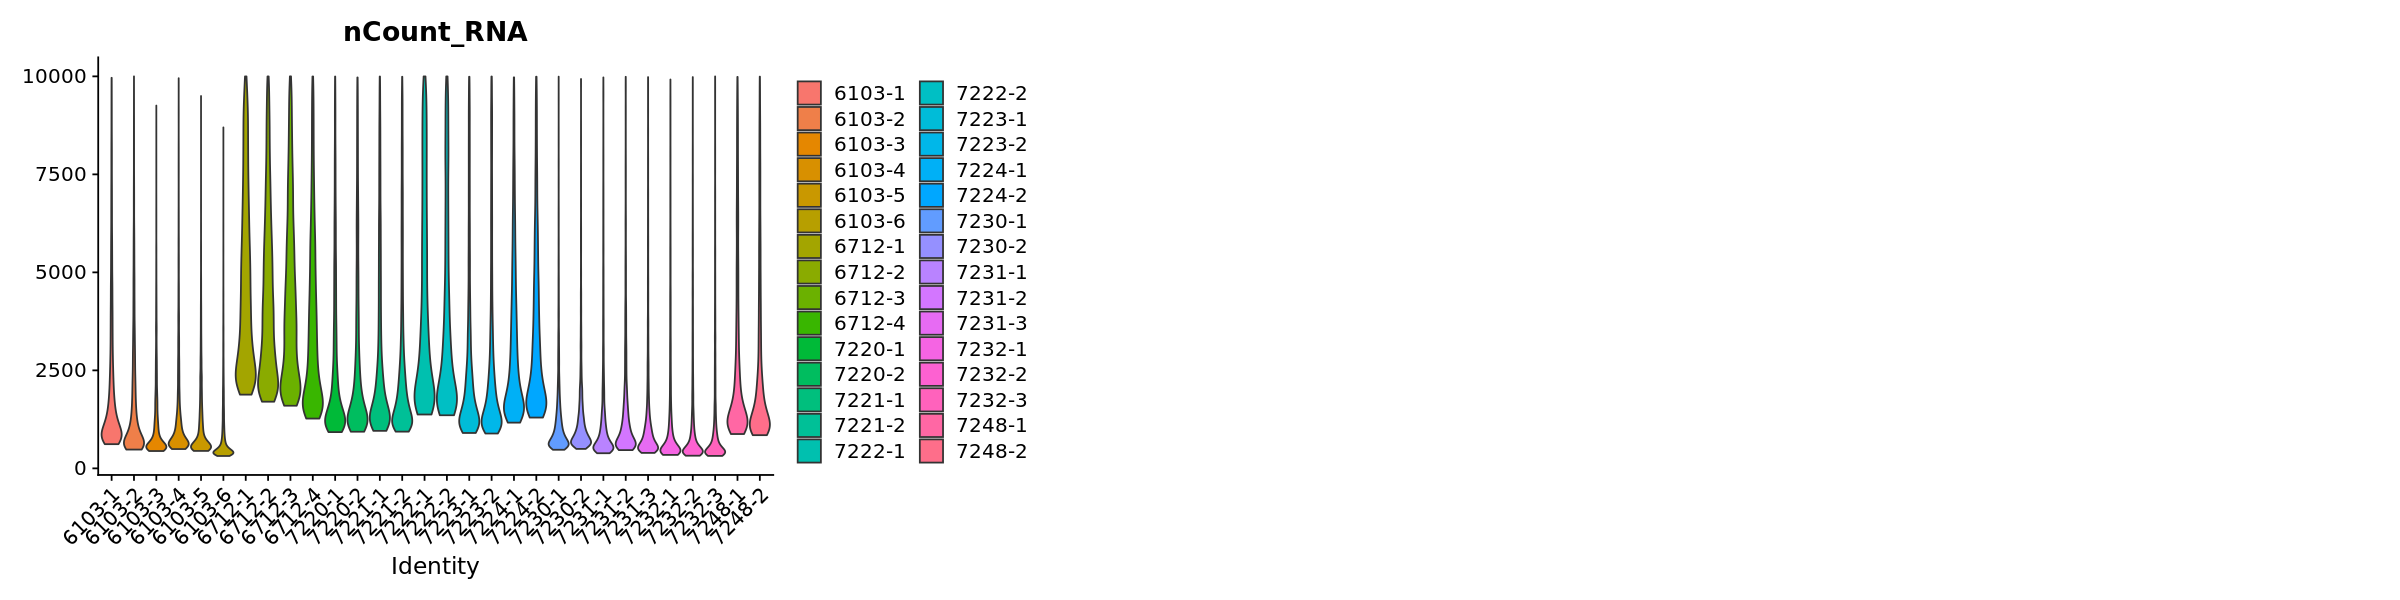

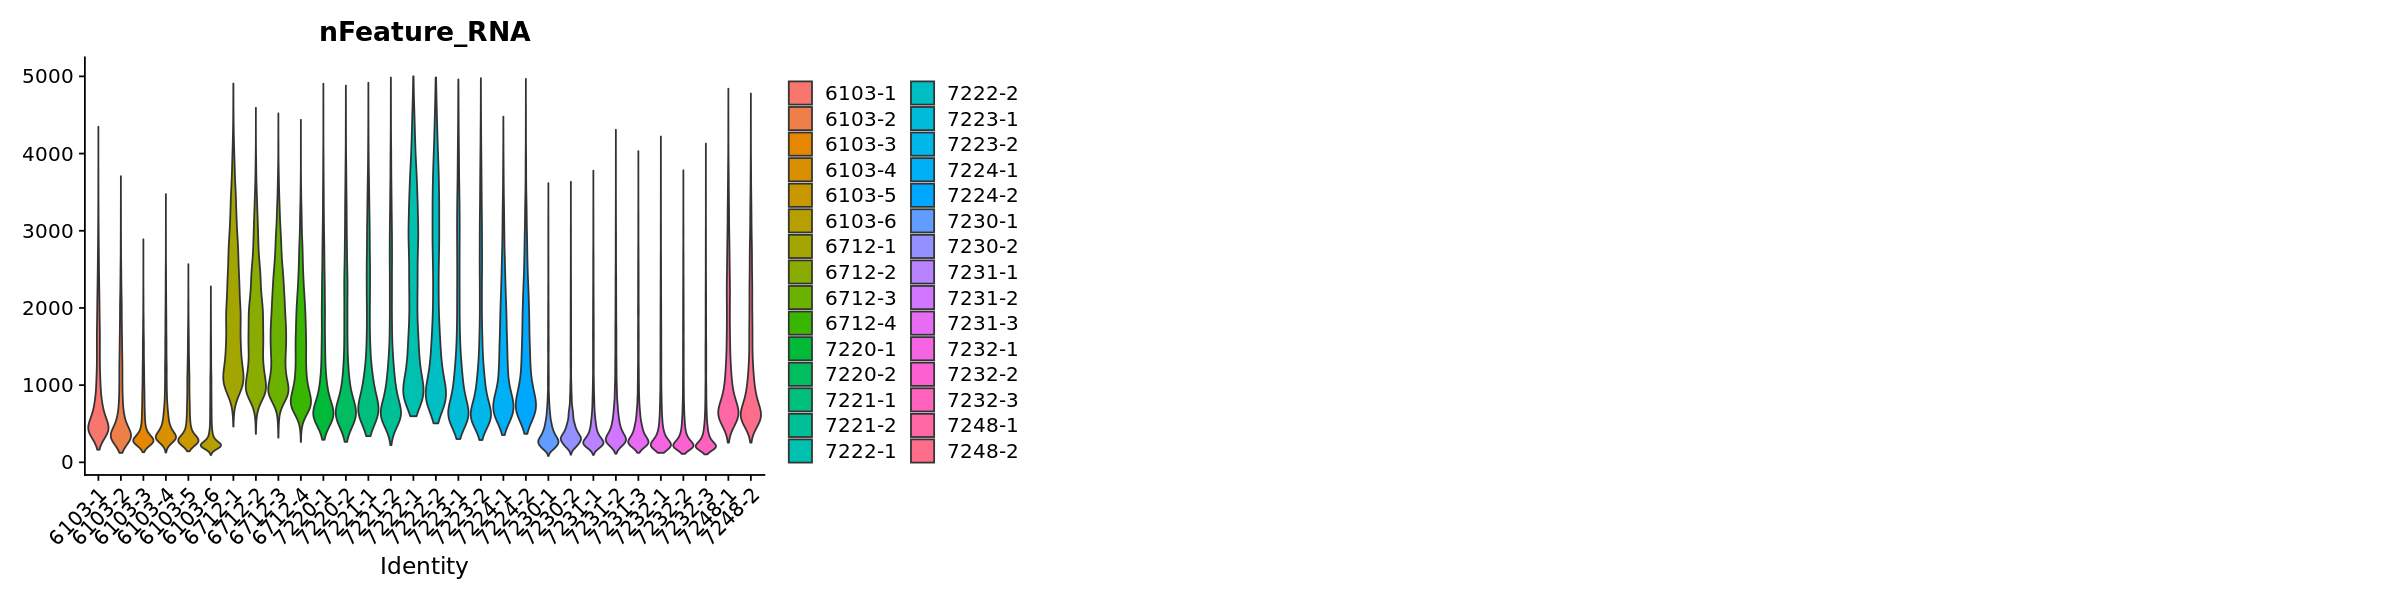

In [6]:
options(repr.plot.height=5,repr.plot.width=20)

VlnPlot(pbmc, features = c( "nCount_RNA"),pt.size = 0, y.max=10000,ncol = 3, group.by="group")

VlnPlot(pbmc, features = c( "nFeature_RNA"),pt.size = 0, y.max=5000,ncol = 3, group.by="group")


